### 범주형 변수의 카디널리티를 살펴봄으로써 적합한 인코딩 방식을 도출하기 위한 코드

실제 인코딩은 categorical_encoding.ipynb로

In [57]:
import pandas as pd
file_path = "data.csv"
df = pd.read_csv(file_path)

In [58]:
cols_to_drop = [col for col in df.columns if col.startswith("서울_")]
df = df.drop(columns=cols_to_drop)

In [ ]:
print(df.columns)

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'NanumGothic' # matplotlib 한글깨짐 해결
mpl.rcParams['axes.unicode_minus'] = False

# 결측치 확인

In [69]:
# 컬럼별 결측치 개수 확인
missing_counts = df.isna().sum()
print(missing_counts)

영화명                0
개봉일             4011
장르                 0
국적                47
감독              1834
배급사             3828
대표국적              47
등급              3877
제작사             5219
배우              3807
누적관객수              0
날짜                 0
순위                 0
매출액                0
총매출액               0
매출액(점유율)           0
매출액증감              0
매출액증감율(전일대비)       0
관객수                0
관객수증감(전일대비)        0
관객수증감율(전일대비)       0
스크린수               0
상영횟수               0
상영일수               0
서울_상영영화수           0
서울_영화관람객수          0
서울_지출금액            0
서울_인구당영화관람객수       0
서울_영화관람객수점수        0
서울_지출금액점수          0
서울_종합점수            0
서울_기준상영영화수         0
서울_기준영화관람객수        0
서울_기준지출금액          0
dtype: int64


In [70]:
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
print(missing_counts)

개봉일     4011
국적        47
감독      1834
배급사     3828
대표국적      47
등급      3877
제작사     5219
배우      3807
dtype: int64


In [71]:
# 컬럼별 결측치 개수 계산
missing_counts = df.isna().sum()

# 컬럼별 결측치 비율(%) 계산
missing_percent = df.isna().mean() * 100

# 결측치가 하나라도 있는 컬럼만 필터링
missing_counts = missing_counts[missing_counts > 0]
missing_percent = missing_percent[missing_percent > 0]

# 결과를 DataFrame으로 합치기
missing_df = pd.DataFrame({
    '결측치_개수': missing_counts,
    '결측치_비율(%)': missing_percent
})

print(missing_df)

      결측치_개수  결측치_비율(%)
개봉일     4011  60.315789
국적        47   0.706767
감독      1834  27.578947
배급사     3828  57.563910
대표국적      47   0.706767
등급      3877  58.300752
제작사     5219  78.481203
배우      3807  57.248120


장르: 해당 행을 drop하기

국적과 대표국적은 최빈값으로 채워도 될 것 같음

감독: 감독 미상 등으로 일단 처리해보기

배급사: 배급사 미상 등으로 처리

등급, 제작사: 컬럼 드랍

배우: 상위 n% 배우만 남겨서 binary encoding

# 장르

In [44]:
import pandas as pd

df_copy = df.copy()
df_copy['장르_list'] = df_copy['장르'].fillna('').str.split(',')
df_exploded_genre = df_copy.explode('장르_list')
df_exploded_genre = df_exploded_genre[df_exploded_genre['장르_list'] != '']
genre_cardinality = df_exploded_genre['장르_list'].nunique()

print("장르의 카디널리티:", genre_cardinality)

장르의 카디널리티: 28


### 평균 상영일수 확인

In [45]:
genre_mean = df.groupby('장르')['상영일수'].mean()
genre_mean = genre_mean.sort_values(ascending=False)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

df['장르'] = df['장르'].str.split(',')

df_exploded = df.explode('장르')
genre_mean = (
    df_exploded
    .groupby('장르')['상영일수']
    .mean()
    .sort_values(ascending=False)
)

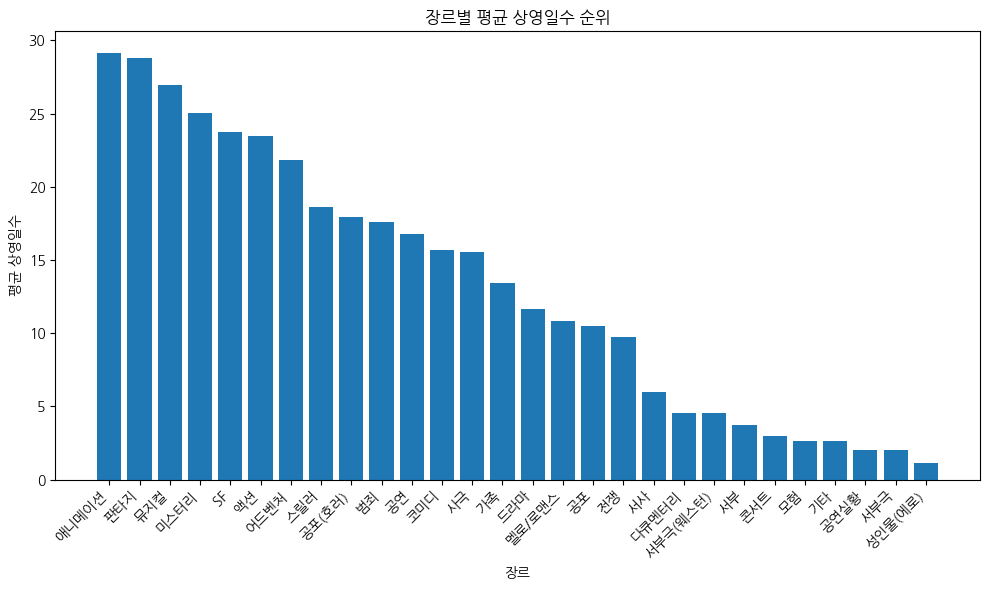

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(genre_mean.index, genre_mean.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('장르')
plt.ylabel('평균 상영일수')
plt.title('장르별 평균 상영일수 순위')
plt.tight_layout()
plt.show()

카디널리티가 높지 않으므로 28차원의 벡터로 **One-Hot Encoding** 진행 후,

피쳐 중요도 분석을 통해 추후 학습에 사용할 주요 장르 컬럼을 선택

이때, 장르별 상영일수 평균 기여도를 계산하여 **Target Encoding**을 함께 진행

# 국적

- 카디널리티: 80
- 영화 수가 50개 이상인 국가의 수: 15개

주요 국가 외에서 영화 수와 상영일수가 현저히 떨어지므로,
상위 15개 국가 제외, `기타`와 나머지 국가를 Other로 묶어 처리

처리된 국가 범주에 대해서는 장르와 동일하게 처리(**One-Hot Encoding + Target Encoding**)

In [41]:
import pandas as pd

df_copy = df.copy()
df_copy['국적_list'] = df_copy['국적'].fillna('').str.split(',')

df_exploded = df_copy.explode('국적_list')
df_exploded = df_exploded[df_exploded['국적_list'] != '']
cardinality = df_exploded['국적_list'].nunique()

print("국적 컬럼의 카디널리티(유니크 국가 수):", cardinality)

국적 컬럼의 카디널리티(유니크 국가 수): 80


### 국적별 영화 수 확인

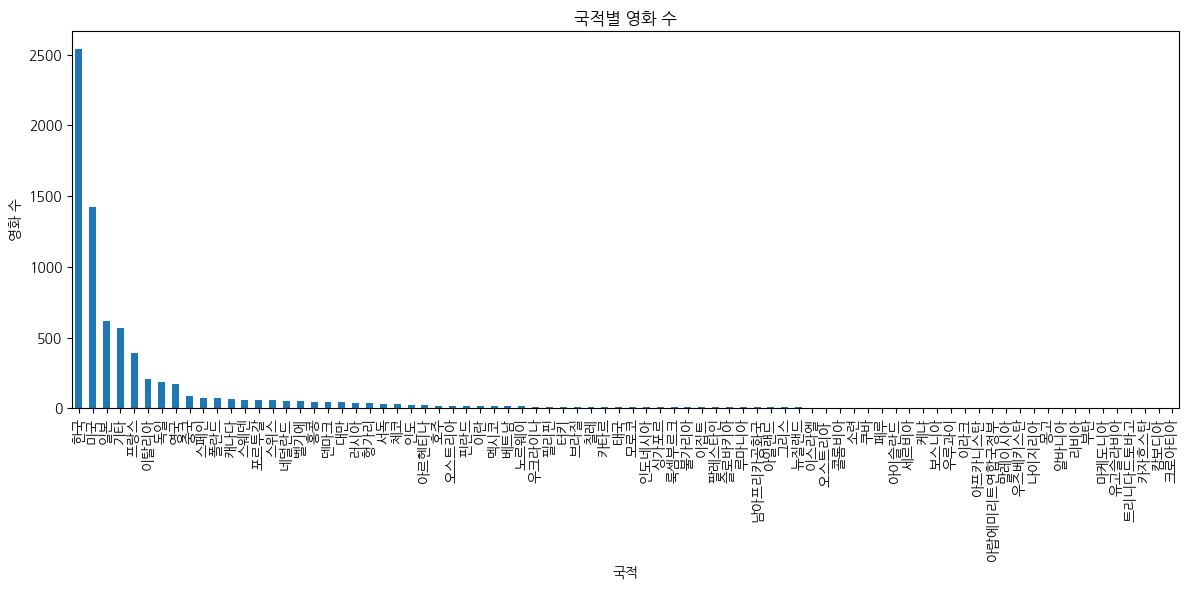

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 원본 df를 그대로 두고, 처리용 복사본을 만듭니다.
df_copy = df.copy()

# 1) '국적' 컬럼의 NaN을 빈 문자열로 대체한 뒤, 쉼표(,) 기준으로 분리하여 리스트로 변환
#    (원본 df에는 영향을 주지 않기 위해 df_copy에서 작업)
df_copy['국적_list'] = df_copy['국적'].fillna('').str.split(',')

# 2) explode를 이용해 국적별로 한 행씩 분리 (원본 df가 아닌 df_copy에서)
df_exploded = df_copy.explode('국적_list')

# 3) 빈 문자열로 된 행(원래 결측 혹은 빈 문자열이었던 경우) 제거
df_exploded = df_exploded[df_exploded['국적_list'] != '']

# 4) 국적별 영화 수 계산
nationality_counts = df_exploded['국적_list'].value_counts().sort_values(ascending=False)

# 5) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
nationality_counts.plot(kind='bar')
plt.xlabel('국적')
plt.ylabel('영화 수')
plt.title('국적별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

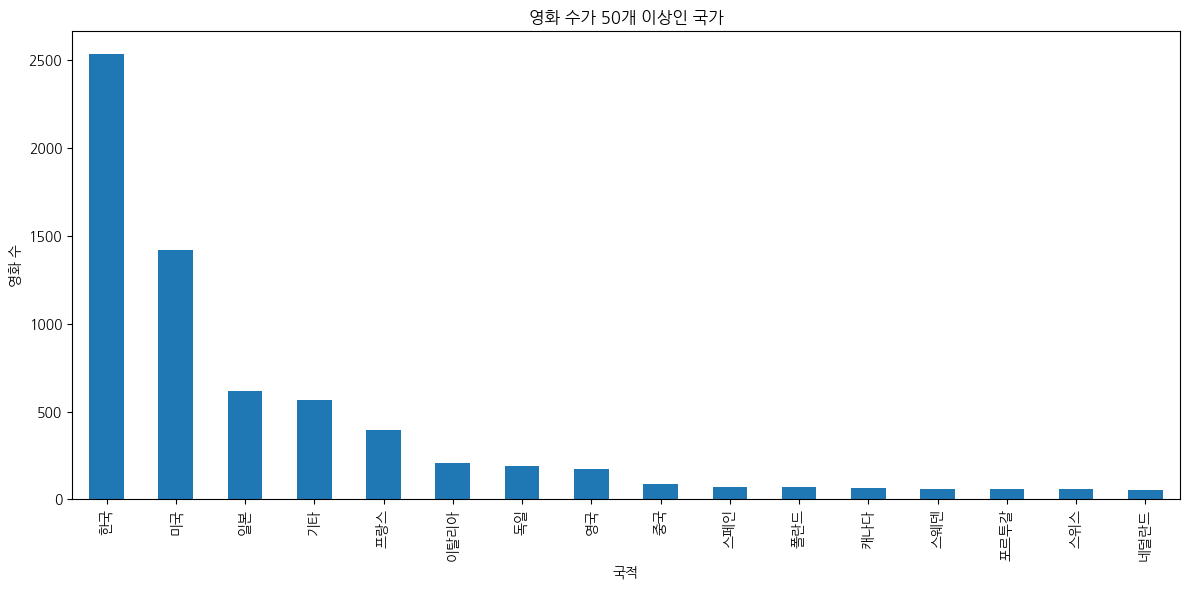

In [51]:
# 상위 영화를 필터링
# 5) 영화 수가 100개 이상인 국가만 필터링
nationality_over_100 = nationality_counts[nationality_counts >= 50].sort_values(ascending=False)

# 6) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
nationality_over_100.plot(kind='bar')
plt.xlabel('국적')
plt.ylabel('영화 수')
plt.title('영화 수가 50개 이상인 국가')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [52]:
genre_mean = df.groupby('국적')['상영일수'].mean()
genre_mean = genre_mean.sort_values(ascending=False)

### 국적별 평균 상영일수 확인

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

df['국적'] = df['국적'].str.split(',')

df_exploded = df.explode('국적')
genre_mean = (
    df_exploded
    .groupby('국적')['상영일수']
    .mean()
    .sort_values(ascending=False)
)

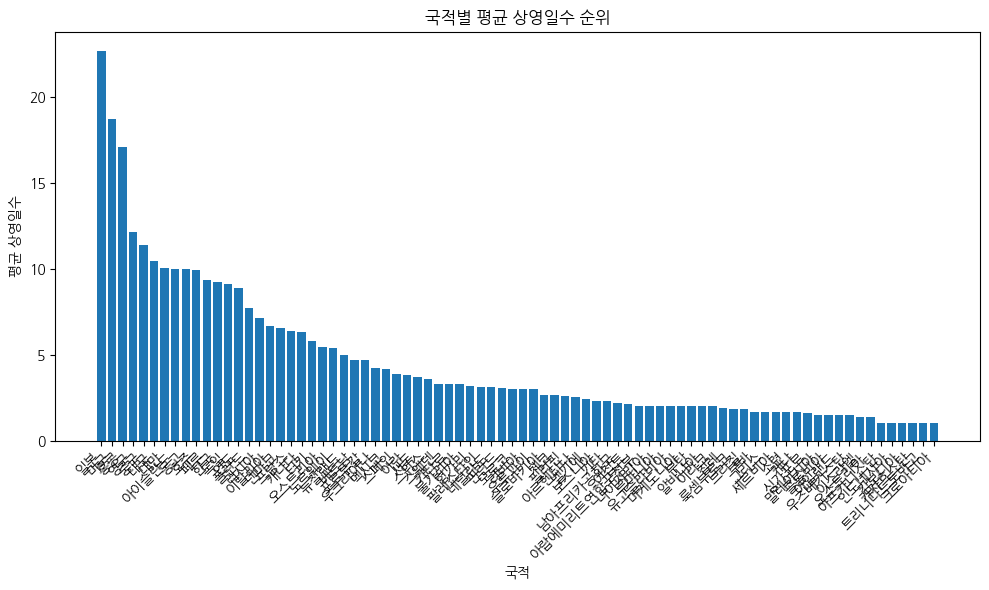

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(genre_mean.index, genre_mean.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('국적')
plt.ylabel('평균 상영일수')
plt.title('국적별 평균 상영일수 순위')
plt.tight_layout()
plt.show()

### 대표국적 

In [55]:
# '대표국적' 컬럼에 리스트이거나 쉼표(,)가 포함된 다중값이 있는지 검사

# 리스트 타입인 경우를 마스크로 생성
mask_list = df['대표국적'].apply(lambda x: isinstance(x, list))

# 문자열 타입이고 ','가 포함된 경우를 마스크로 생성
mask_comma = df['대표국적'].apply(lambda x: isinstance(x, str) and ',' in x)

# 두 마스크를 합쳐 다중값이 있는 행만 선택
df_multi_nationality = df[mask_list | mask_comma]

국적과 동일하게 처리

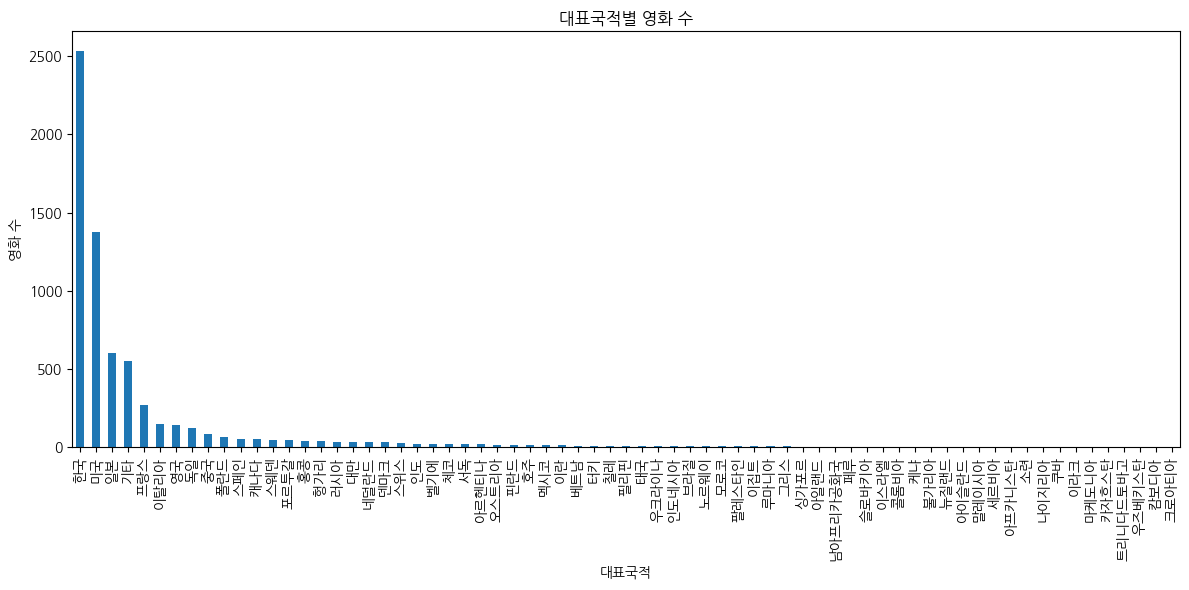

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# 원본 df를 그대로 두고, 처리용 복사본을 만듭니다.
df_copy = df.copy()

# 1) '국적' 컬럼의 NaN을 빈 문자열로 대체한 뒤, 쉼표(,) 기준으로 분리하여 리스트로 변환
#    (원본 df에는 영향을 주지 않기 위해 df_copy에서 작업)
df_copy['대표국적_list'] = df_copy['대표국적'].fillna('').str.split(',')

# 2) explode를 이용해 국적별로 한 행씩 분리 (원본 df가 아닌 df_copy에서)
df_exploded = df_copy.explode('대표국적_list')

# 3) 빈 문자열로 된 행(원래 결측 혹은 빈 문자열이었던 경우) 제거
df_exploded = df_exploded[df_exploded['대표국적_list'] != '']

# 4) 국적별 영화 수 계산
nationality_counts = df_exploded['대표국적_list'].value_counts().sort_values(ascending=False)

# 5) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
nationality_counts.plot(kind='bar')
plt.xlabel('대표국적')
plt.ylabel('영화 수')
plt.title('대표국적별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

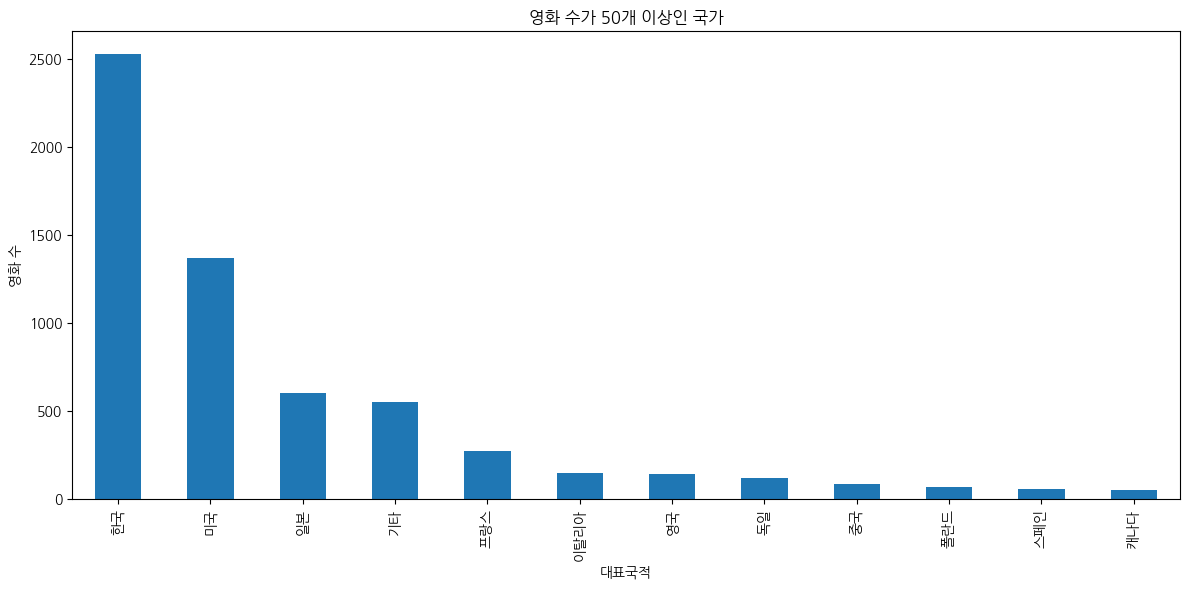

In [61]:
# 상위 영화를 필터링
# 5) 영화 수가 100개 이상인 국가만 필터링
nationality_over_100 = nationality_counts[nationality_counts >= 50].sort_values(ascending=False)

# 6) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
nationality_over_100.plot(kind='bar')
plt.xlabel('대표국적')
plt.ylabel('영화 수')
plt.title('영화 수가 50개 이상인 국가')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [43]:
genre_mean = df.groupby('대표국적')['상영일수'].mean()
genre_mean = genre_mean.sort_values(ascending=False)

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

df['대표국적'] = df['대표국적'].str.split(',')

df_exploded = df.explode('대표국적')
genre_mean = (
    df_exploded
    .groupby('대표국적')['상영일수']
    .mean()
    .sort_values(ascending=False)
)

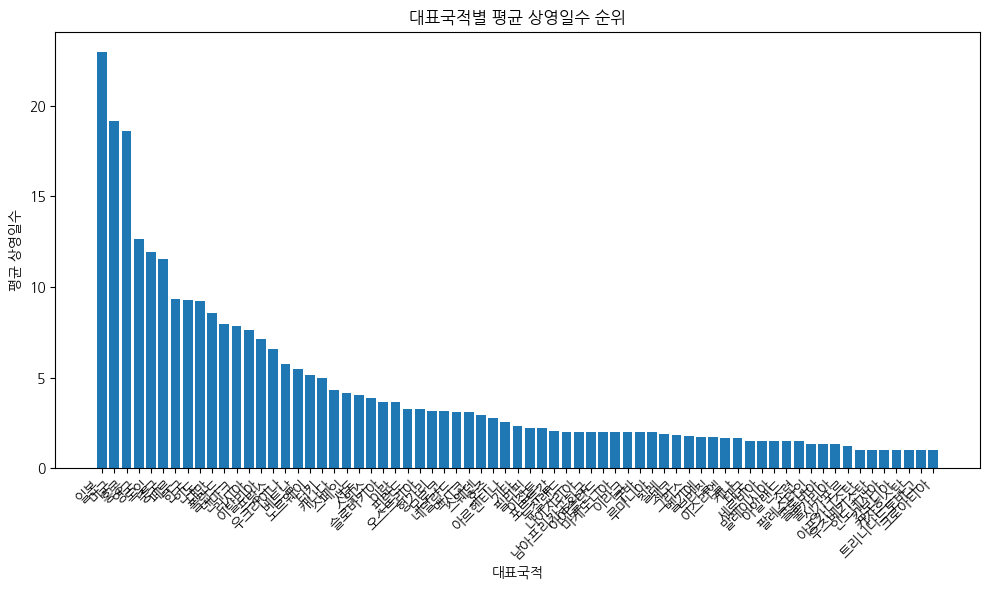

In [57]:
plt.figure(figsize=(10, 6))
plt.bar(genre_mean.index, genre_mean.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('대표국적')
plt.ylabel('평균 상영일수')
plt.title('대표국적별 평균 상영일수 순위')
plt.tight_layout()
plt.show()

# 등급

결측치가 많아서 사용하지 않는 것으로 결정

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

df['등급'] = df['등급'].str.split(',')

df_exploded = df.explode('등급')
genre_mean = (
    df_exploded
    .groupby('등급')['상영일수']
    .mean()
    .sort_values(ascending=False)
)

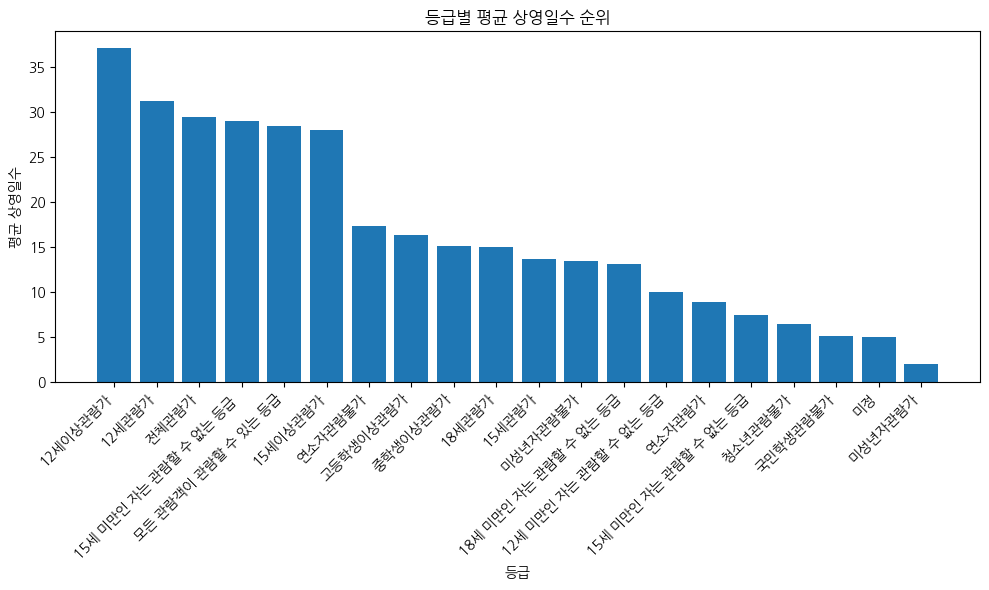

In [48]:
plt.figure(figsize=(10, 6))
plt.bar(genre_mean.index, genre_mean.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('등급')
plt.ylabel('평균 상영일수')
plt.title('등급별 평균 상영일수 순위')
plt.tight_layout()
plt.show()

# 배우

In [74]:
import pandas as pd

df_copy = df.copy()
df_copy['배우_list'] = df_copy['배우'].fillna('').str.split(',')
df_exploded_actor = df_copy.explode('배우_list')
df_exploded_actor = df_exploded_actor[df_exploded_actor['배우_list'] != '']
actor_cardinality = df_exploded_actor['배우_list'].nunique()

print("배우 컬럼의 카디널리티(유니크 배우 수):", actor_cardinality)

배우 컬럼의 카디널리티(유니크 배우 수): 11746


### 배우 지표 확인

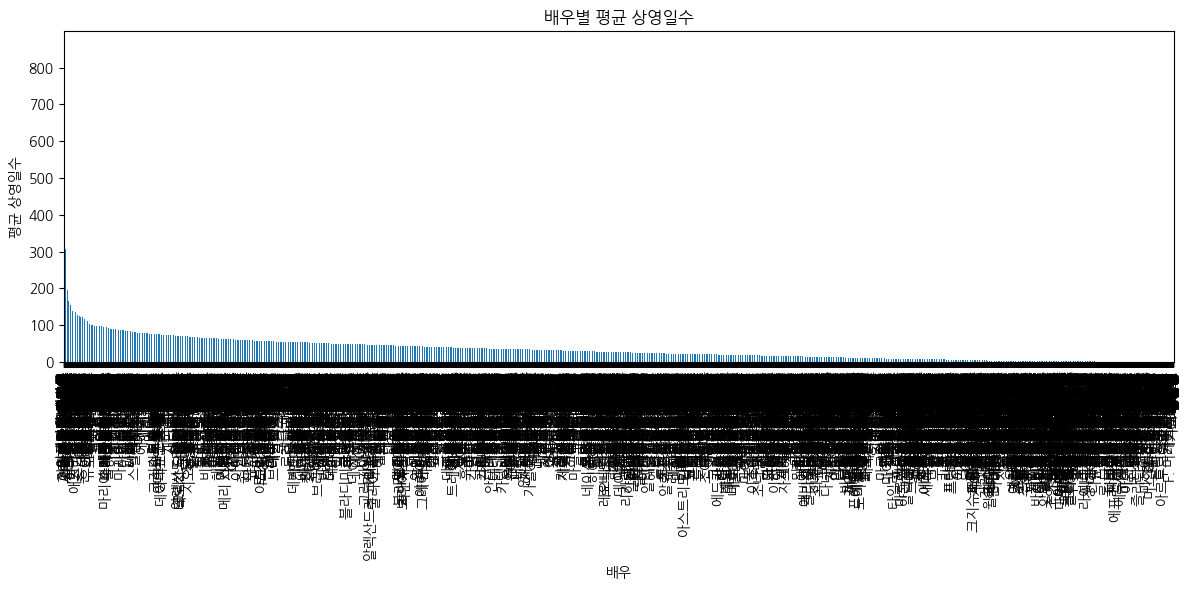

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) '배우' 컬럼의 NaN을 빈 문자열로 대체
df['배우'] = df['배우'].fillna('')

# 2) '배우' 문자열을 쉼표(,) 기준으로 분리하여 리스트로 변환
df['배우_list'] = df['배우'].apply(lambda x: x.split(',') if x != '' else [])

# 3) explode를 이용해 배우별로 한 행씩 분리
df_exploded = df.explode('배우_list')

# 4) 빈 문자열로 된 배우(결측 처리된 경우) 행 제거
df_exploded = df_exploded[df_exploded['배우_list'] != '']

# 5) 배우별 평균 상영일수 계산
actor_mean_days = df_exploded.groupby('배우_list')['상영일수'].mean().sort_values(ascending=False)

# 6) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
actor_mean_days.plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('평균 상영일수')
plt.title('배우별 평균 상영일수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


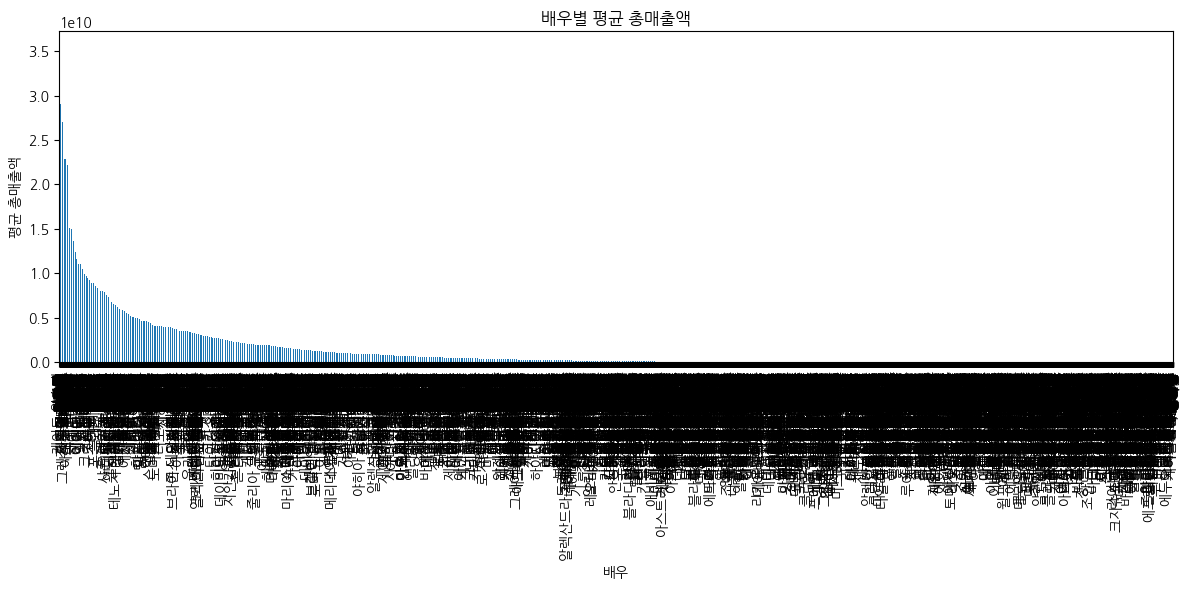

In [58]:
# 5) 배우별 평균 총매출액 계산
#    '총매출액' 컬럼이 존재한다고 가정합니다.
actor_mean_revenue = df_exploded.groupby('배우_list')['총매출액'].mean().sort_values(ascending=False)

# 6) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
actor_mean_revenue.plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('평균 총매출액')
plt.title('배우별 평균 총매출액')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


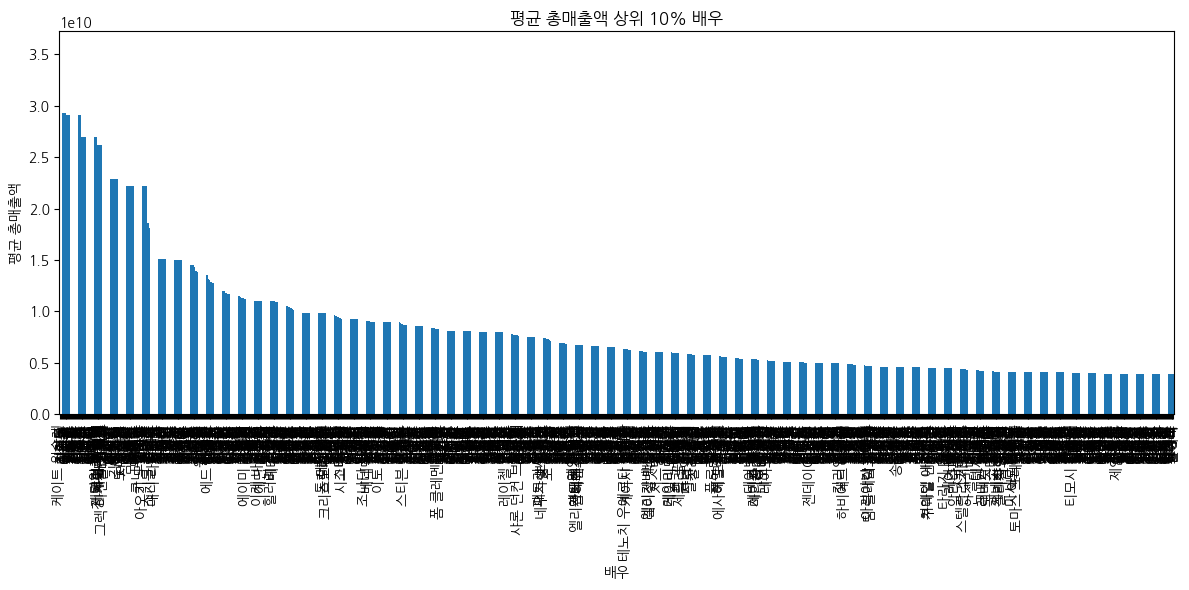

In [63]:
import matplotlib.pyplot as plt

# 1) 평균 총매출액의 90번째 분위수(상위 10% 컷오프) 계산
threshold = actor_mean_revenue.quantile(0.90)

# 2) 상위 10%에 해당하는 배우들 필터링
top_10pct_actors = actor_mean_revenue[actor_mean_revenue >= threshold]

# 3) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
top_10pct_actors.plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('평균 총매출액')
plt.title('평균 총매출액 상위 10% 배우')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


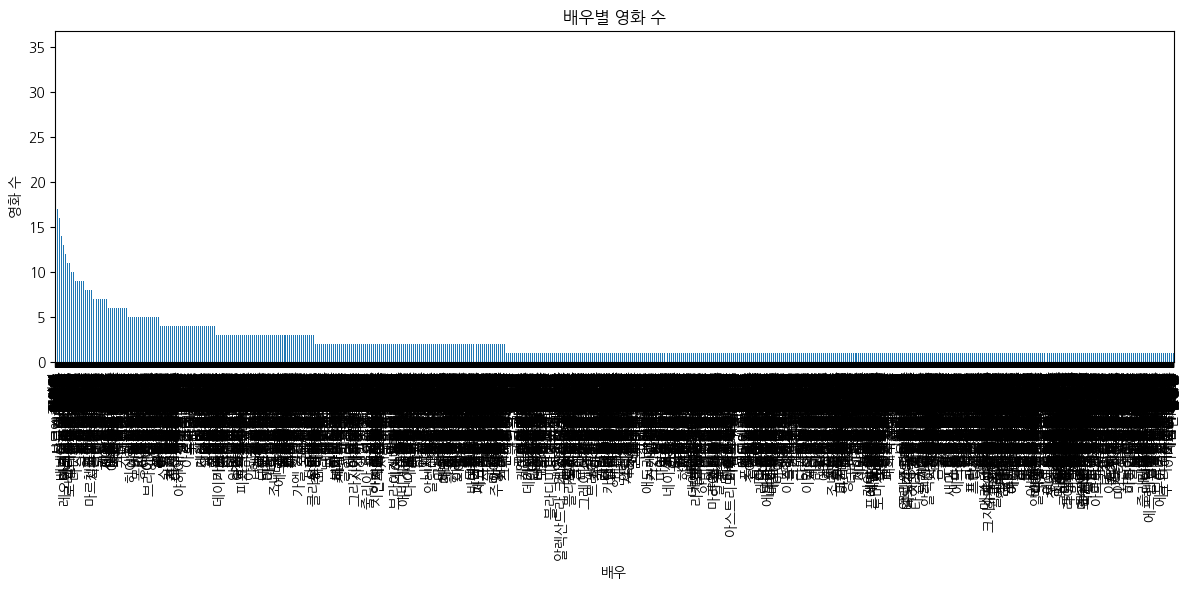

In [59]:
# 5) 배우별 영화수(출현 행 수) 계산
actor_movie_count = df_exploded['배우_list'].value_counts().sort_values(ascending=False)

# 6) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
actor_movie_count.plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('영화 수')
plt.title('배우별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

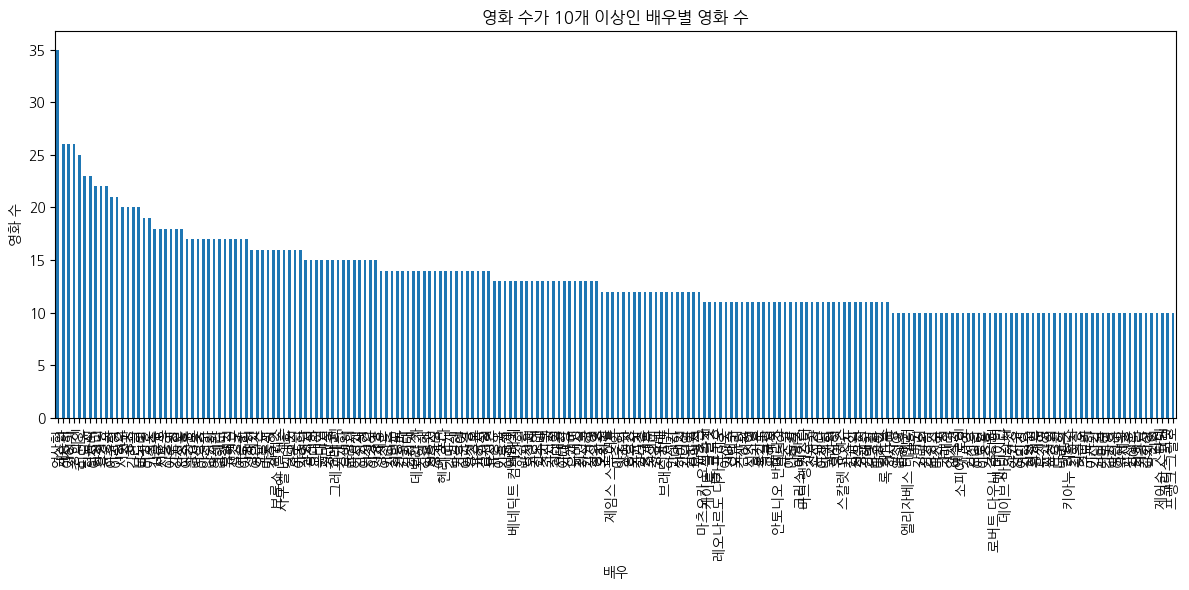

In [62]:
# 6) 영화 수가 2개 이상인 배우만 필터링
actor_movie_count_filtered = actor_movie_count[actor_movie_count >= 10].sort_values(ascending=False)

# 7) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
actor_movie_count_filtered.plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('영화 수')
plt.title('영화 수가 10개 이상인 배우별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### 지표에 로그스케일링 적용

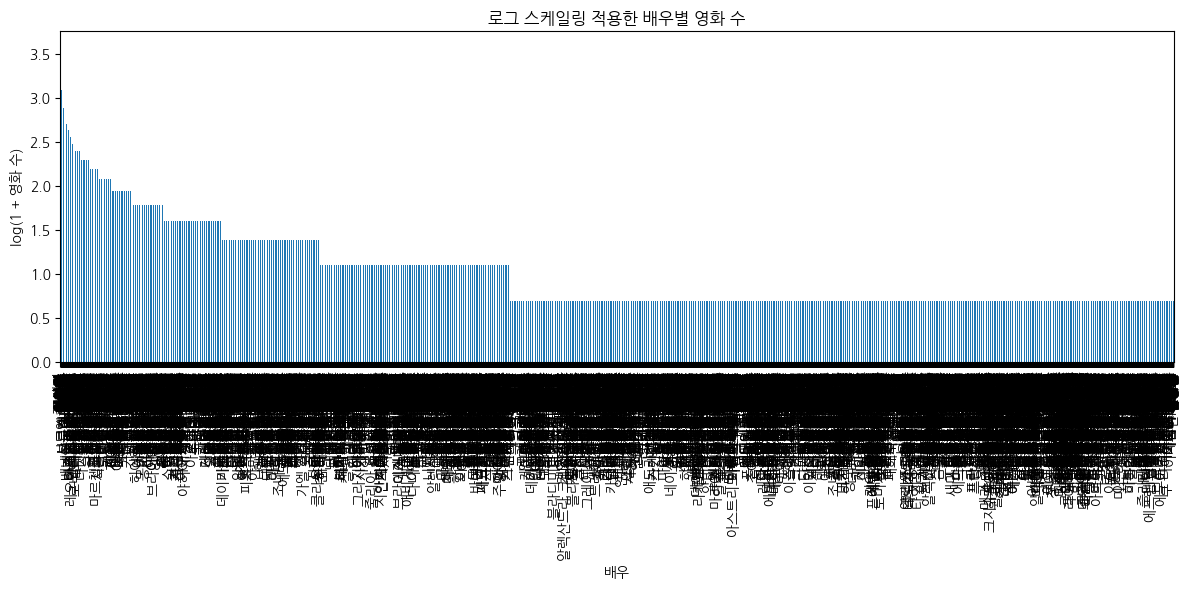

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 원본 df를 보존하기 위해 복사본 생성
df_copy = df.copy()

# 2) '배우' 컬럼을 NaN → '' 처리 후, 쉼표(,) 기준으로 리스트로 변환
df_copy['배우_list'] = df_copy['배우'].fillna('').str.split(',')

# 3) explode로 배우별로 한 행씩 분리
df_exploded = df_copy.explode('배우_list')

# 4) 빈 문자열(결측) 제거
df_exploded = df_exploded[df_exploded['배우_list'] != '']

# 5) 배우별 영화 수 계산
actor_movie_count = df_exploded['배우_list'].value_counts()

# 6) 로그 스케일링: log(1 + count)
actor_movie_log = np.log1p(actor_movie_count)

# 7) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
actor_movie_log.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('log(1 + 영화 수)')
plt.title('로그 스케일링 적용한 배우별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


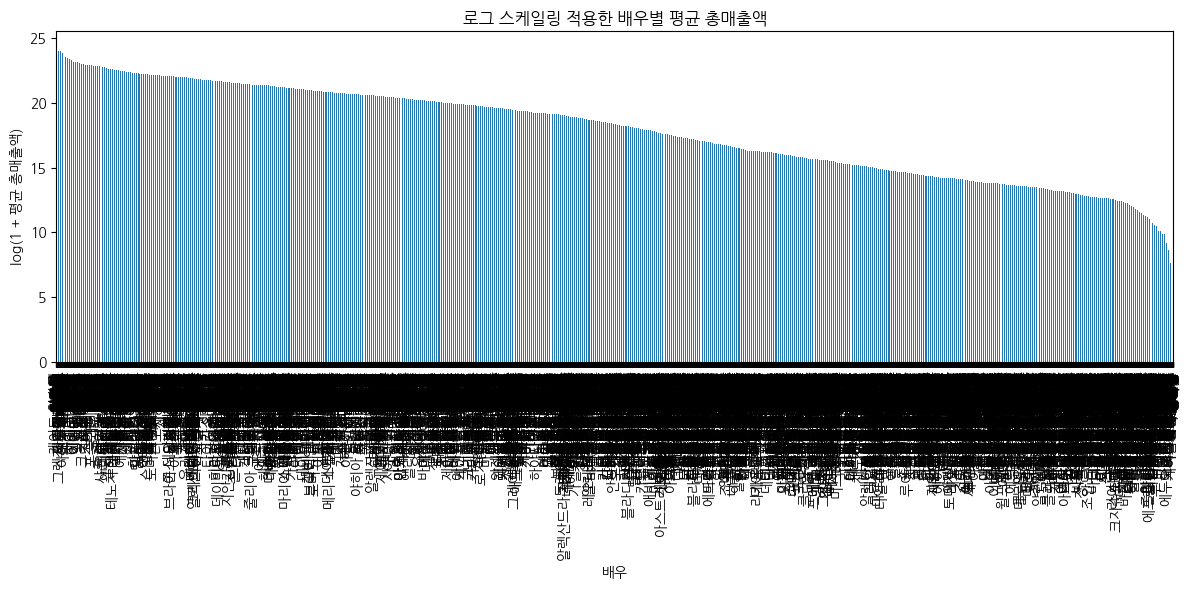

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) 원본 df를 보존하기 위해 복사본 생성
df_copy = df.copy()

# 2) '배우' 컬럼의 NaN을 빈 문자열로 대체한 뒤, 쉼표(,) 기준으로 리스트로 변환
df_copy['배우_list'] = df_copy['배우'].fillna('').str.split(',')

# 3) explode를 이용해 배우별로 한 행씩 분리
df_exploded = df_copy.explode('배우_list')

# 4) 빈 문자열(결측) 제거
df_exploded = df_exploded[df_exploded['배우_list'] != '']

# 5) 배우별 평균 총매출액 계산
actor_mean_revenue = df_exploded.groupby('배우_list')['총매출액'].mean()

# 6) 로그 스케일로 변환 (log(1 + avg_revenue))
actor_revenue_log = np.log1p(actor_mean_revenue)

# 7) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
actor_revenue_log.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('log(1 + 평균 총매출액)')
plt.title('로그 스케일링 적용한 배우별 평균 총매출액')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 배우별 점수 계산 및 시각화

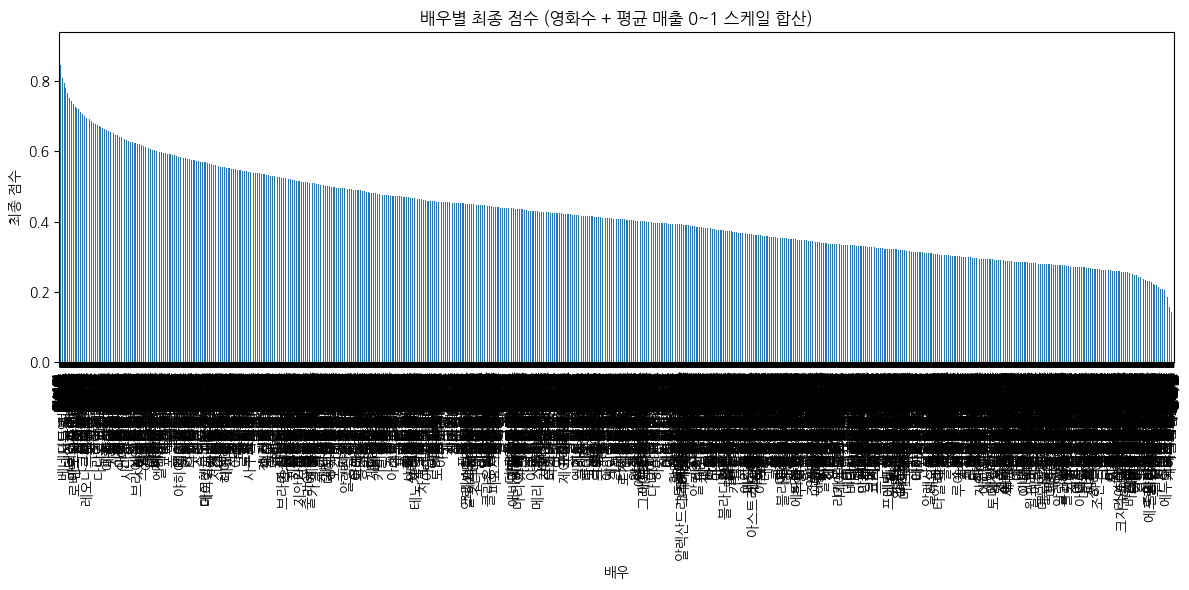

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 원본 df를 보존하기 위해 복사본 생성
df_copy = df.copy()

# 배우별 영화 수 계산
df_copy['배우_list'] = df_copy['배우'].fillna('').str.split(',')
df_exploded = df_copy.explode('배우_list')
df_exploded = df_exploded[df_exploded['배우_list'] != '']
actor_movie_count = df_exploded['배우_list'].value_counts()

# 배우별 평균 총매출액 계산
actor_mean_revenue = df_exploded.groupby('배우_list')['총매출액'].mean()

# 로그 변환
count_log = np.log1p(actor_movie_count)
revenue_log = np.log1p(actor_mean_revenue)

# Min–Max 스케일링
count_min, count_max = count_log.min(), count_log.max()
revenue_min, revenue_max = revenue_log.min(), revenue_log.max()

count_scaled = (count_log - count_min) / (count_max - count_min)
revenue_scaled = (revenue_log - revenue_min) / (revenue_max - revenue_min)

# 두 스케일을 병합하고 최종 점수 계산
df_scores = pd.DataFrame({
    'count_scaled': count_scaled,
    'revenue_scaled': revenue_scaled
}).dropna()

df_scores['final_score'] = (df_scores['count_scaled'] + df_scores['revenue_scaled']) / 2
df_scores = df_scores.sort_values('final_score', ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
df_scores['final_score'].plot(kind='bar')
plt.xlabel('배우')
plt.ylabel('최종 점수')
plt.title('배우별 최종 점수 (영화수 + 평균 매출 0~1 스케일 합산)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [91]:
# 최고 점수 데이터프레임(df_scores)이 이미 만들어져 있다고 가정합니다.

# 1) 상위 10% 컷오프 계산
threshold = df_scores['final_score'].quantile(0.99)

# 2) 상위 10% 배우만 필터링
top_1pct_actors = df_scores[df_scores['final_score'] >= threshold]

# 3) 결과 출력 및 개수 계산
print(top_1pct_actors)
print("상위 1% 배우 수:", len(top_1pct_actors))


         count_scaled  revenue_scaled  final_score
배우_list                                           
정인기          0.900469        0.888774     0.894622
엄상현          1.000000        0.782121     0.891061
현봉식          0.859719        0.918878     0.889299
황정민          0.844994        0.905126     0.875060
이상희          0.900469        0.840344     0.870406
...               ...             ...          ...
오윤수          0.647599        0.853736     0.750667
차래형          0.589802        0.911475     0.750639
김현지          0.697109        0.802223     0.749666
임용순          0.697109        0.802080     0.749594
김현우          0.589802        0.907849     0.748825

[118 rows x 3 columns]
상위 1% 배우 수: 118


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 가정: 원본 df에는 적어도 '배우'와 '총매출액' 컬럼이 있으며,
#        '배우' 컬럼은 "배우A,배우B,배우C" 같은 문자열 형태로 되어 있음.

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result = df.copy()
df_result['actor_oof_score'] = np.nan  # 여기에 영화별 배우 평균 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, 섞기 적용, 시드 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 배우 점수 계산 → 검증(fold_val)에 영화별 배우 평균 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]
    
    # 3-2) 훈련 subset에서 배우별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_exp = df_train.copy()
    df_train_exp['배우_list'] = df_train_exp['배우'].fillna('').str.split(',')
    df_train_exp = df_train_exp.explode('배우_list')
    df_train_exp = df_train_exp[df_train_exp['배우_list'] != '']  # 빈 문자열(결측) 제거
    
    # 3-3) 배우별 “영화 출연 횟수” 집계
    actor_movie_count = df_train_exp['배우_list'].value_counts()
    
    # 3-4) 배우별 “평균 총매출액” 집계
    actor_mean_revenue = (
        df_train_exp
        .groupby('배우_list')['총매출액']
        .mean()
    )
    
    # 3-5) 로그 변환
    count_log = np.log1p(actor_movie_count)         # log(1 + count)
    revenue_log = np.log1p(actor_mean_revenue)      # log(1 + avg_revenue)
    
    # 3-6) Min–Max 스케일링
    #      각 시리즈가 동일한 인덱스(배우 이름)를 갖지는 않을 수 있으므로, 
    #      스케일링은 각각의 시리즈 내부에서 수행하고 나중에 합침
    c_min, c_max = count_log.min(), count_log.max()
    r_min, r_max = revenue_log.min(), revenue_log.max()
    
    count_scaled = (count_log - c_min) / (c_max - c_min)
    revenue_scaled = (revenue_log - r_min) / (r_max - r_min)
    
    # 3-7) 최종 배우 점수 계산 (영화수 vs 평균매출 평균)
    actor_score = (count_scaled + revenue_scaled) / 2
    #    → actor_score: index=배우이름, value=log→minmax→평균으로 계산된 값 (0~1 내부)
    
   # (3-7) 이후, actor_score를 구한 직후에 기본값(평균 배우 점수)을 계산합니다.
    default_score = actor_score.mean()

    # (3-8) 검증용 subset(fold_val)에 대해서 “영화별 배우 평균 점수” 계산 및 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        actor_str = df_result.at[movie_idx, '배우']
        
        # 배우 데이터가 없으면 해당 fold의 전체 배우 평균 점수로 채웁니다.
        if pd.isna(actor_str) or actor_str.strip() == "":
            df_result.at[movie_idx, 'actor_oof_score'] = default_score
            continue
        
        actor_list = [a.strip() for a in actor_str.split(',') if a.strip() != ""]
        scores = actor_score.reindex(actor_list).fillna(default_score)
        df_result.at[movie_idx, 'actor_oof_score'] = scores.mean()


# 4) 결과: df_result['actor_oof_score'] 열에 “영화별 배우들의 평균 OOF 점수”가 저장됨
print(df_result[['배우', 'actor_oof_score']].head())


                                                  배우  actor_oof_score
0  카미키 류노스케,카미시라이시 모네,나가사와 마사미,이치하라 에수코,유키 아오이,시마...         0.437766
1                 다이고 코타로,모리 나나,오구리 슌,심규혁,최한,강은애,김서영         0.496007
2                                                NaN         0.422873
3               엠마 스톤,라이언 고슬링,핀 위트록,J.K. 시몬스,로즈마리 드윗         0.465949
4  오가타 메구미,하나자와 카나,코마츠 미카코,우치야마 코우키,세키 토모카즈,나카무라 ...         0.428448


C:\Users\user\AppData\Local\Temp\ipykernel_15400\746996306.py:11: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15400\746996306.py:11: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15400\746996306.py:11: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15400\746996306.py:11: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15400\746996306.py:11: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_15400\746996306.py:11: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) 

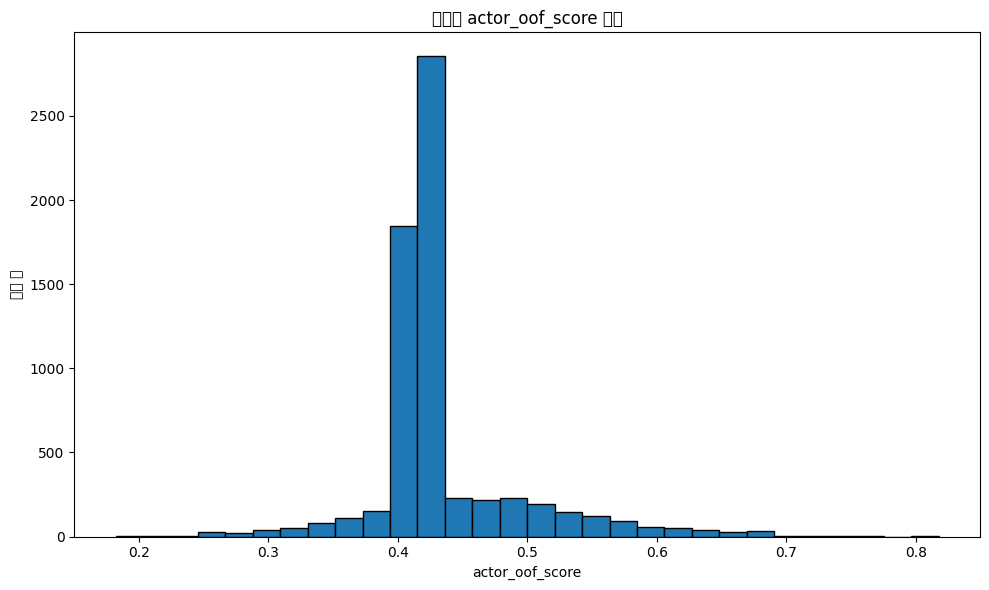

In [5]:
import matplotlib.pyplot as plt

# df_result에는 'actor_oof_score' 컬럼이 있다고 가정합니다.

# 1) 영화별 actor_oof_score 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df_result['actor_oof_score'].dropna(), bins=30, edgecolor='black')
plt.xlabel('actor_oof_score')
plt.ylabel('영화 수')
plt.title('영화별 actor_oof_score 분포')
plt.tight_layout()
plt.show()

In [6]:
# actor_oof_score 기준으로 내림차순 정렬
df_result = df_result.sort_values(by='actor_oof_score', ascending=False).reset_index(drop=True)
df_result[['영화명', '배우', '상영일수', 'actor_oof_score']]

,영화명,배우,상영일수,actor_oof_score
0,정브르의 동물일기,이정현,17,0.817726
1,다만 악에서 구하소서 파이널컷,"황정민,이정재,박정민",34,0.812646
2,리코더시험,"정인기,박명신",6,0.799494
3,무명 無名,하정우,2,0.771911
4,가나의 혼인잔치: 언약,장광,70,0.769006
...,...,...,...,...
6645,첫경험이 무려 나나미,카와카미 나나미,1,0.236968
6646,메리 포핀스,줄리 앤드류스,2,0.231854
6647,철남2,타구치 토모로오,12,0.218617
6648,오빠 남진 라이브 콘서트,남진,7,0.203842


평균 점수를 사용하면

티켓파워가 높은 배우가 있어도, 무명배우가 같이 포함되어있어 제대로 배우의 영향을 반영하지 못하는 문제가 발생함

하여, 평균 점수 대신 영화 중 가장 점수가 높은 배우의 점수로 채워서 진행

결측값은 평균으로 대체

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 가정: 원본 df에는 적어도 '배우'와 '총매출액' 컬럼이 있으며,
#        '배우' 컬럼은 "배우A,배우B,배우C" 같은 문자열 형태로 되어 있음.

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result = df.copy()
df_result['actor_oof_score'] = np.nan  # 여기에 영화별 배우 최고 OOF 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, 섞기 적용, 시드 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 배우 점수 계산 → 검증(fold_val)에 영화별 배우 최고 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]
    
    # 3-2) 훈련 subset에서 배우별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_exp = df_train.copy()
    df_train_exp['배우_list'] = df_train_exp['배우'].fillna('').str.split(',')
    df_train_exp = df_train_exp.explode('배우_list')
    df_train_exp = df_train_exp[df_train_exp['배우_list'] != '']  # 빈 문자열(결측) 제거
    
    # 3-3) 배우별 “영화 출연 횟수” 집계
    actor_movie_count = df_train_exp['배우_list'].value_counts()
    
    # 3-4) 배우별 “평균 총매출액” 집계
    actor_mean_revenue = (
        df_train_exp
        .groupby('배우_list')['총매출액']
        .mean()
    )
    
    # 3-5) 로그 변환
    count_log = np.log1p(actor_movie_count)         # log(1 + count)
    revenue_log = np.log1p(actor_mean_revenue)      # log(1 + avg_revenue)
    
    # 3-6) Min–Max 스케일링
    c_min, c_max = count_log.min(), count_log.max()
    r_min, r_max = revenue_log.min(), revenue_log.max()
    
    count_scaled = (count_log - c_min) / (c_max - c_min)
    revenue_scaled = (revenue_log - r_min) / (r_max - r_min)
    
    # 3-7) 최종 배우 점수 계산 (영화수 vs 평균매출 평균)
    actor_score = (count_scaled + revenue_scaled) / 2
    #    → actor_score: index=배우이름, value=log→minmax→평균으로 계산된 값 (0~1 내부)
    
    # (3-7) 이후, actor_score를 구한 직후에 기본값(평균 배우 점수)을 계산합니다.
    default_score = actor_score.mean()

    # (3-8) 검증용 subset(fold_val)에 대해서 “영화별 배우 최고 점수” 계산 및 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        actor_str = df_result.at[movie_idx, '배우']
        
        # 배우 데이터가 없으면 해당 fold의 전체 배우 평균 점수로 채웁니다.
        if pd.isna(actor_str) or actor_str.strip() == "":
            df_result.at[movie_idx, 'actor_oof_score'] = default_score
            continue
        
        actor_list = [a.strip() for a in actor_str.split(',') if a.strip() != ""]
        scores = actor_score.reindex(actor_list).fillna(default_score)
        
        # 영화별 “배우 최고 점수” = 출연 배우 점수들의 최대값
        df_result.at[movie_idx, 'actor_oof_score'] = scores.max()

# 4) 결과: df_result['actor_oof_score'] 열에 “영화별 배우들의 최고 OOF 점수”가 저장됨
print(df_result[['배우', 'actor_oof_score']].head())


                                                  배우  actor_oof_score
0  카미키 류노스케,카미시라이시 모네,나가사와 마사미,이치하라 에수코,유키 아오이,시마...         0.600941
1                 다이고 코타로,모리 나나,오구리 슌,심규혁,최한,강은애,김서영         0.645516
2                                                NaN         0.422873
3               엠마 스톤,라이언 고슬링,핀 위트록,J.K. 시몬스,로즈마리 드윗         0.598436
4  오가타 메구미,하나자와 카나,코마츠 미카코,우치야마 코우키,세키 토모카즈,나카무라 ...         0.507004


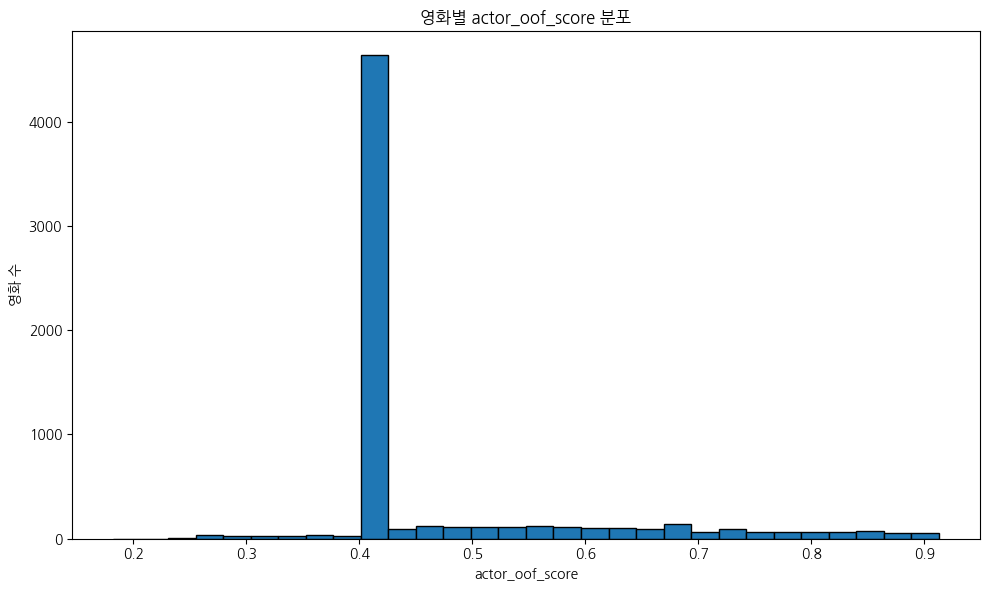

In [97]:
import matplotlib.pyplot as plt

# df_result에는 'actor_oof_score' 컬럼이 있다고 가정합니다.

# 1) 영화별 actor_oof_score 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df_result['actor_oof_score'].dropna(), bins=30, edgecolor='black')
plt.xlabel('actor_oof_score')
plt.ylabel('영화 수')
plt.title('영화별 actor_oof_score 분포')
plt.tight_layout()
plt.show()

In [102]:
# actor_oof_score 기준으로 내림차순 정렬
df_result = df_result.sort_values(by='actor_oof_score', ascending=False).reset_index(drop=True)
df_result[['영화명', '배우', '상영일수', 'actor_oof_score']]

,영화명,배우,상영일수,actor_oof_score
0,파일럿,"조정석,이주명,한선화,신승호,오민애,김지현,서재희,박다온,현봉식,서현철,유재석,조세...",99,0.912778
1,승부,"이병헌,유아인,고창석,현봉식,문정희,김강훈,조우진,김이산",52,0.912778
2,F20,"장영남,김정영,이지하,김미화,유서진,김강민,유동훈,구지혜,옥주리,김서연,정민교,신선...",25,0.909100
3,육사오(6/45),"이학주,고경표,이이경,음문석,박세완,이순원,곽동연,김민호,류승수,윤병희,이준혁,신원...",69,0.909100
4,소리꾼,"이봉근,이유리,김하연,박철민,김동완,한인수,정무성,임성철,김병춘,김강현,박재민,지태...",49,0.909100
...,...,...,...,...
6645,첫경험이 무려 나나미,카와카미 나나미,1,0.236968
6646,메리 포핀스,줄리 앤드류스,2,0.231854
6647,철남2,타구치 토모로오,12,0.218617
6648,오빠 남진 라이브 콘서트,남진,7,0.203842


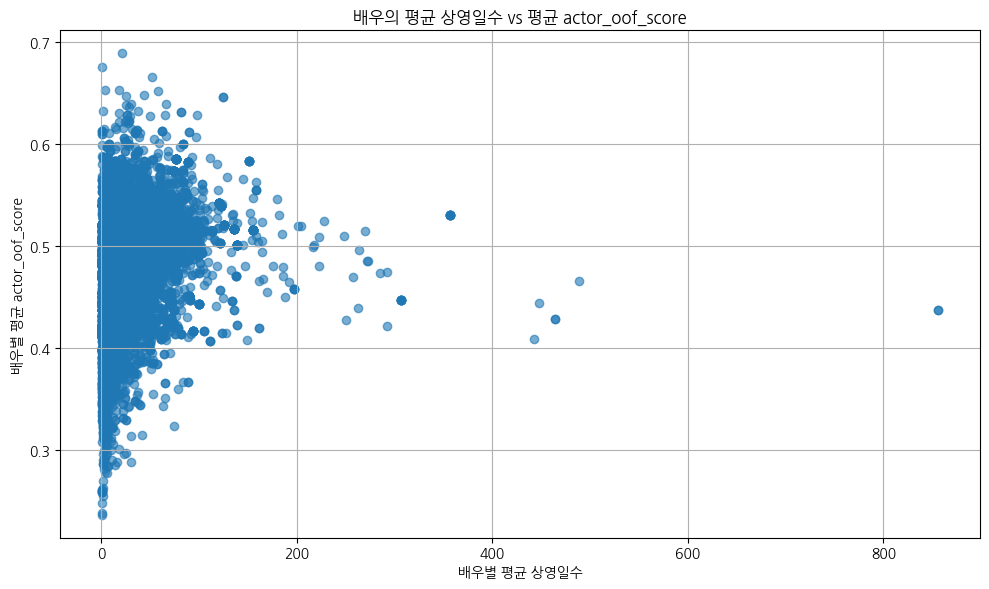

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 'df_result'가 이미 정의되어 있다고 가정합니다.
# df_result에는 '배우', '상영일수', 'actor_oof_score' 컬럼이 있어야 합니다.

# 1) 배우 컬럼을 explode 처리
df_actor = df_result.copy()
df_actor['배우_list'] = df_actor['배우'].fillna('').str.split(',')
df_actor_exploded = df_actor.explode('배우_list')
df_actor_exploded = df_actor_exploded[df_actor_exploded['배우_list'] != '']

# 2) 배우별 평균 상영일수 계산
actor_mean_days = df_actor_exploded.groupby('배우_list')['상영일수'].mean()

# 3) 배우별 평균 actor_oof_score 계산
actor_mean_score = df_actor_exploded.groupby('배우_list')['actor_oof_score'].mean()

# 4) 배우별 데이터 프레임 합치기
actor_df = pd.DataFrame({
    'avg_days': actor_mean_days,
    'avg_oof_score': actor_mean_score
}).dropna()

# 5) 산점도 시각화
plt.figure(figsize=(10, 6))
plt.scatter(actor_df['avg_days'], actor_df['avg_oof_score'], alpha=0.6)
plt.xlabel('배우별 평균 상영일수')
plt.ylabel('배우별 평균 actor_oof_score')
plt.title('배우의 평균 상영일수 vs 평균 actor_oof_score')
plt.grid(True)
plt.tight_layout()
plt.show()


# 감독

### 감독의 카디널리티 확인

In [12]:
# 리스트 타입인 경우를 마스크로 생성
mask_list = df['감독'].apply(lambda x: isinstance(x, list))

# 문자열 타입이고 ','가 포함된 경우를 마스크로 생성
mask_comma = df['감독'].apply(lambda x: isinstance(x, str) and ',' in x)

# 두 마스크를 합쳐 다중값이 있는 행만 선택
df_multi_director = df[mask_list | mask_comma]

감독도 다중값임

In [ ]:
import pandas as pd

df_copy = df.copy()
df_copy['감독_list'] = df_copy['감독'].fillna('').str.split(',')
df_exploded_director = df_copy.explode('감독_list')
df_exploded_director = df_exploded_director[df_exploded_director['감독_list'] != '']
director_cardinality = df_exploded_director['감독_list'].nunique()

print("감독 컬럼의 카디널리티(유니크 감독 수):", director_cardinality)

감독 컬럼의 카디널리티(유니크 감독 수): 3053


### 감독 지표 시각화

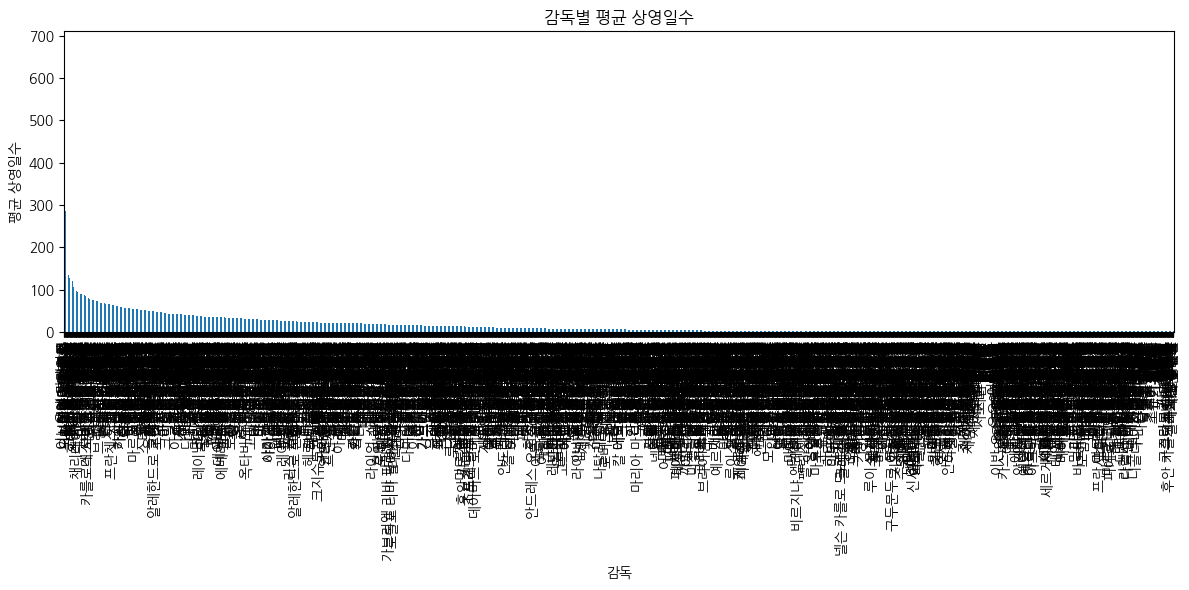

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df_copy = df.copy()
df_copy['감독_list'] = df_copy['감독'].fillna('').str.split(',')
df_exploded = df_copy.explode('감독_list')
df_exploded = df_exploded[df_exploded['감독_list'] != '']

director_mean_days = (
    df_exploded
    .groupby('감독_list')['상영일수']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 6))
director_mean_days.plot(kind='bar')
plt.xlabel('감독')
plt.ylabel('평균 상영일수')
plt.title('감독별 평균 상영일수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


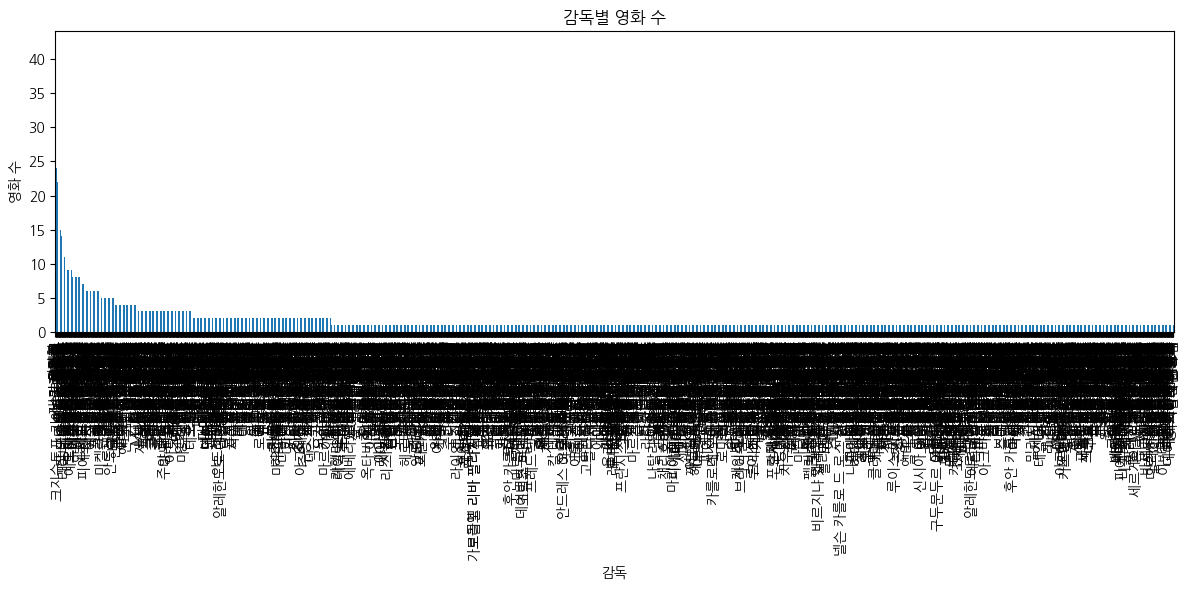

In [18]:
# 4) 감독별 영화 수 계산
director_counts = df_exploded['감독_list'].value_counts().sort_values(ascending=False)

# 5) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
director_counts.plot(kind='bar')
plt.xlabel('감독')
plt.ylabel('영화 수')
plt.title('감독별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


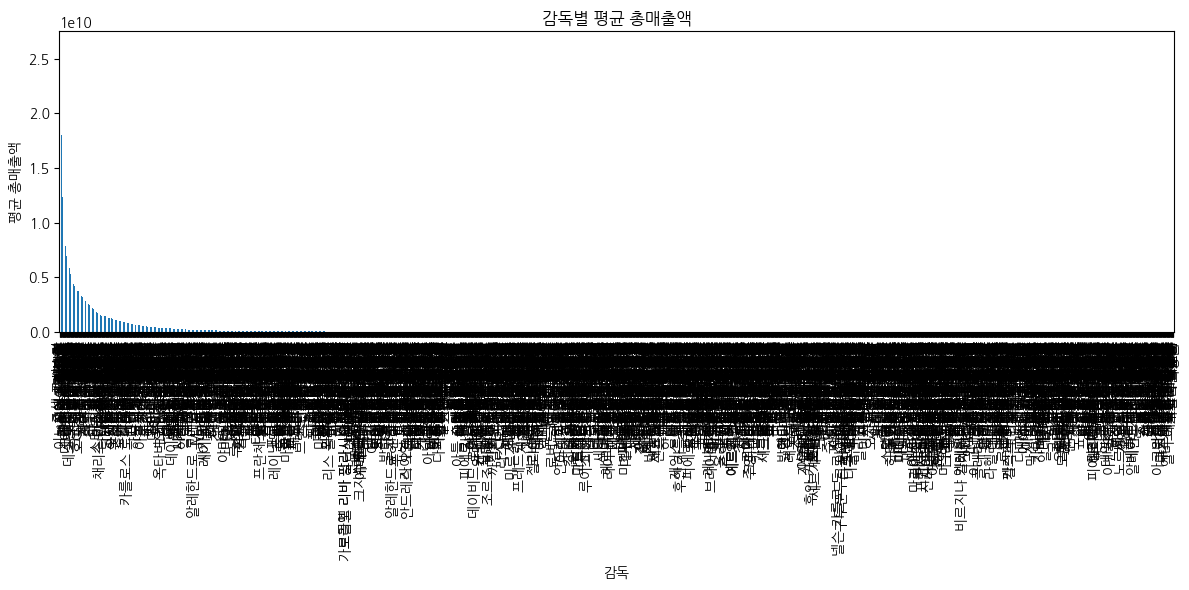

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 원본 df를 보존하기 위해 복사본 생성
df_copy = df.copy()

# 1) '감독' 컬럼을 NaN → '' 처리한 뒤, 쉼표(,) 기준으로 리스트로 변환
df_copy['감독_list'] = df_copy['감독'].fillna('').str.split(',')

# 2) explode를 이용해 감독별로 한 행씩 분리
df_exploded = df_copy.explode('감독_list')

# 3) 빈 문자열(결측) 제거
df_exploded = df_exploded[df_exploded['감독_list'] != '']

# 4) 감독별 평균 총매출액 계산
director_mean_revenue = df_exploded.groupby('감독_list')['총매출액'].mean().sort_values(ascending=False)

# 5) 막대 그래프로 시각화
plt.figure(figsize=(12, 6))
director_mean_revenue.plot(kind='bar')
plt.xlabel('감독')
plt.ylabel('평균 총매출액')
plt.title('감독별 평균 총매출액')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 감독에 대한 oof 점수 계산

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 가정: 원본 df에는 적어도 '감독'과 '총매출액' 컬럼이 있으며,
#        '감독' 컬럼은 "감독A,감독B" 같은 문자열 형태로 되어 있음.

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result = df.copy()
df_result['director_oof_score'] = np.nan  # 여기에 영화별 감독 최고 OOF 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, shuffle=True, random_state 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 감독 점수 계산 → 검증(fold_val)에 영화별 감독 최고 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]

    # 3-2) 훈련 subset에서 감독별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_dir = df_train.copy()
    df_train_dir['감독_list'] = df_train_dir['감독'].fillna('').str.split(',')
    df_train_dir = df_train_dir.explode('감독_list')
    df_train_dir = df_train_dir[df_train_dir['감독_list'] != '']  # 빈 문자열(결측) 제거

    # 3-3) 감독별 “영화 출연 횟수” 집계
    director_movie_count = df_train_dir['감독_list'].value_counts()

    # 3-4) 감독별 “평균 총매출액” 집계
    director_mean_revenue = df_train_dir.groupby('감독_list')['총매출액'].mean()

    # 3-5) 로그 변환
    dir_count_log = np.log1p(director_movie_count)     # log(1 + 영화수)
    dir_rev_log = np.log1p(director_mean_revenue)      # log(1 + 평균매출)

    # 3-6) Min–Max 스케일링
    dc_min, dc_max = dir_count_log.min(), dir_count_log.max()
    dr_min, dr_max = dir_rev_log.min(), dir_rev_log.max()

    director_count_scaled = (dir_count_log - dc_min) / (dc_max - dc_min)
    director_rev_scaled = (dir_rev_log - dr_min) / (dr_max - dr_min)

    # 3-7) 최종 감독 점수 계산 (영화수 vs 평균매출 평균)
    director_score = (director_count_scaled + director_rev_scaled) / 2
    default_director_score = director_score.mean()  # 훈련 내 전체 감독 평균

    # 3-8) 검증용 subset(fold_val)에 영화별 감독 최고 점수 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        director_str = df_result.at[movie_idx, '감독']

        # 감독 데이터가 없으면 해당 fold의 전체 감독 평균 점수로 채운다
        if pd.isna(director_str) or director_str.strip() == "":
            df_result.at[movie_idx, 'director_oof_score'] = default_director_score
            continue

        dir_list = [d.strip() for d in director_str.split(',') if d.strip() != ""]
        d_scores = director_score.reindex(dir_list).fillna(default_director_score)

        # 영화별 “감독 최고 점수” = 출연 감독 점수들의 최대값
        df_result.at[movie_idx, 'director_oof_score'] = d_scores.max()

# 4) 결과: df_result['director_oof_score'] 열에 영화별 감독 최고 OOF 점수가 저장됨
print(df_result[['감독', 'director_oof_score']].head())


          감독  director_oof_score
0    신카이 마코토            0.552973
1    신카이 마코토            0.485728
2  이노우에 다케히코            0.334657
3    데이미언 셔젤            0.432697
4        박성후            0.333402


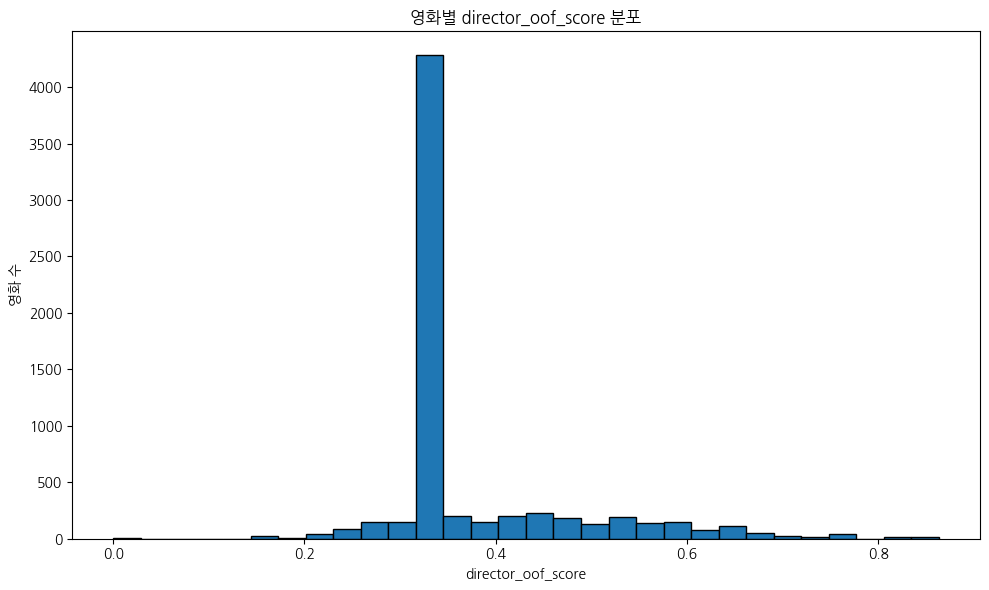

In [23]:
import matplotlib.pyplot as plt

# df_result에는 'director_oof_score' 컬럼이 있다고 가정합니다.

# 1) 영화별 director_oof_score 분포 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(df_result['director_oof_score'].dropna(), bins=30, edgecolor='black')
plt.xlabel('director_oof_score')
plt.ylabel('영화 수')
plt.title('영화별 director_oof_score 분포')
plt.tight_layout()
plt.show()

In [24]:
# director_oof_score 기준으로 내림차순 정렬
df_result = df_result.sort_values(by='director_oof_score', ascending=False).reset_index(drop=True)
df_result[['영화명', '감독', '상영일수', 'director_oof_score']]

,영화명,감독,상영일수,director_oof_score
0,(여자)아이들 월드투어 [아이돌] 인 시네마,오윤동,15,0.863352
1,세븐틴 파워 오브 러브 : 더 무비,오윤동,21,0.863352
2,엔시티 네이션 : 투 더 월드 인 시네마,오윤동,21,0.863352
3,방탄소년단: 옛 투 컴 인 시네마,오윤동,22,0.863352
4,엔시티 드림 더 무비 : 인 어 드림,"이예지,오윤동",14,0.863352
...,...,...,...,...
6645,여자만세,신수원,1,0.000000
6646,비밀은 없다,이경미,3,0.000000
6647,바운더리,윤가현,3,0.000000
6648,물비늘,신수원,1,0.000000


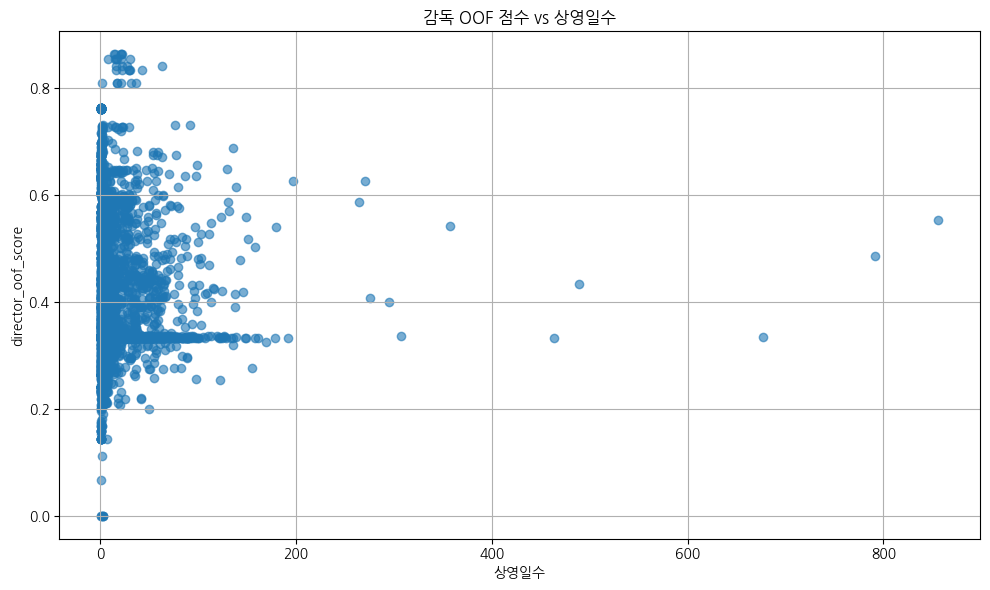

In [27]:
import matplotlib.pyplot as plt

# df_result에는 'director_oof_score'와 '상영일수' 컬럼이 정의되어 있다고 가정합니다.

plt.figure(figsize=(10, 6))
plt.scatter(df_result['상영일수'], df_result['director_oof_score'], alpha=0.6)
plt.xlabel('상영일수')
plt.ylabel('director_oof_score')
plt.title('감독 OOF 점수 vs 상영일수')
plt.grid(True)
plt.tight_layout()
plt.show()


# 배급사

### 배급사의 카디널리티 확인

In [28]:
## 다중값이 있는지 검사
mask_list = df['배급사'].apply(lambda x: isinstance(x, list))
mask_comma = df['배급사'].apply(lambda x: isinstance(x, str) and ',' in x)
df_multi_distributor = df[mask_list | mask_comma]

In [48]:
import pandas as pd

df_copy = df.copy()
df_copy['배급사_list'] = df_copy['배급사'].fillna('').str.split(',')
df_exploded_distributor = df_copy.explode('배급사_list')
df_exploded_distributor = df_exploded_distributor[df_exploded_distributor['배급사_list'] != '']
distributor_cardinality = df_exploded_distributor['배급사_list'].nunique()

print("배급사 컬럼의 카디널리티(유니크 배급사 수):", distributor_cardinality)

배급사 컬럼의 카디널리티(유니크 배급사 수): 423


In [55]:
df_exploded_distributor[['영화명','배급사', '배급사_list']].head(5)

,영화명,배급사,배급사_list
0,너의 이름은.,메가박스중앙(주) 플러스엠 엔터테인먼트,메가박스중앙(주) 플러스엠 엔터테인먼트
1,날씨의 아이,"메가박스중앙(주) 플러스엠 엔터테인먼트,(주)미디어캐슬,워터홀컴퍼니(주)",메가박스중앙(주) 플러스엠 엔터테인먼트
1,날씨의 아이,"메가박스중앙(주) 플러스엠 엔터테인먼트,(주)미디어캐슬,워터홀컴퍼니(주)",(주)미디어캐슬
1,날씨의 아이,"메가박스중앙(주) 플러스엠 엔터테인먼트,(주)미디어캐슬,워터홀컴퍼니(주)",워터홀컴퍼니(주)
2,더 퍼스트 슬램덩크,(주)넥스트엔터테인먼트월드(NEW),(주)넥스트엔터테인먼트월드(NEW)


### 배급사 지표 시각화

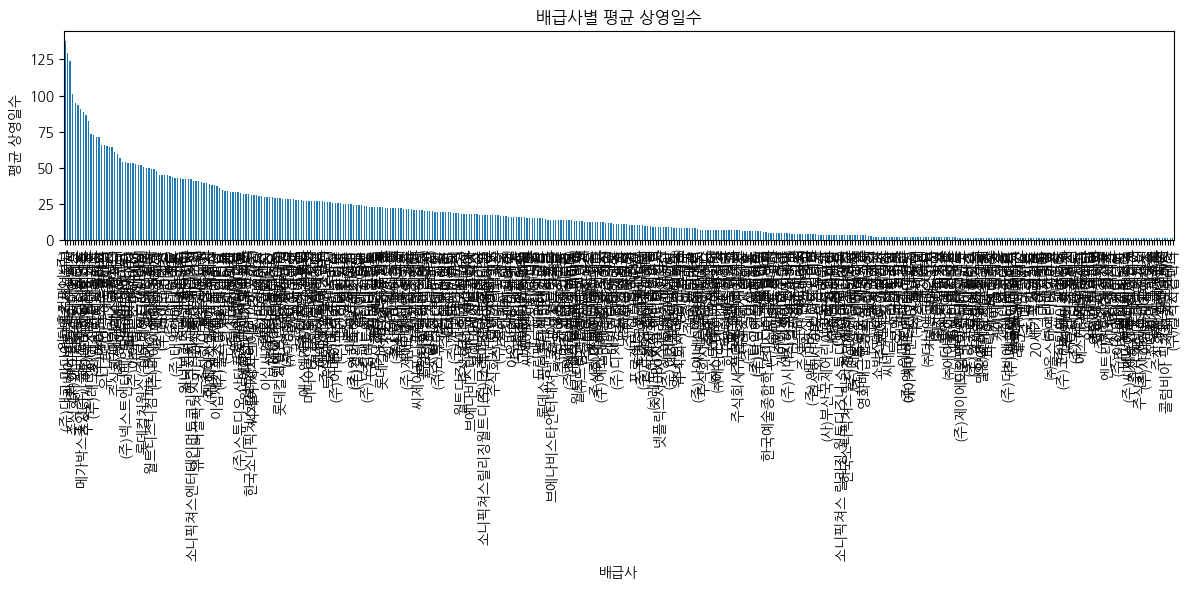

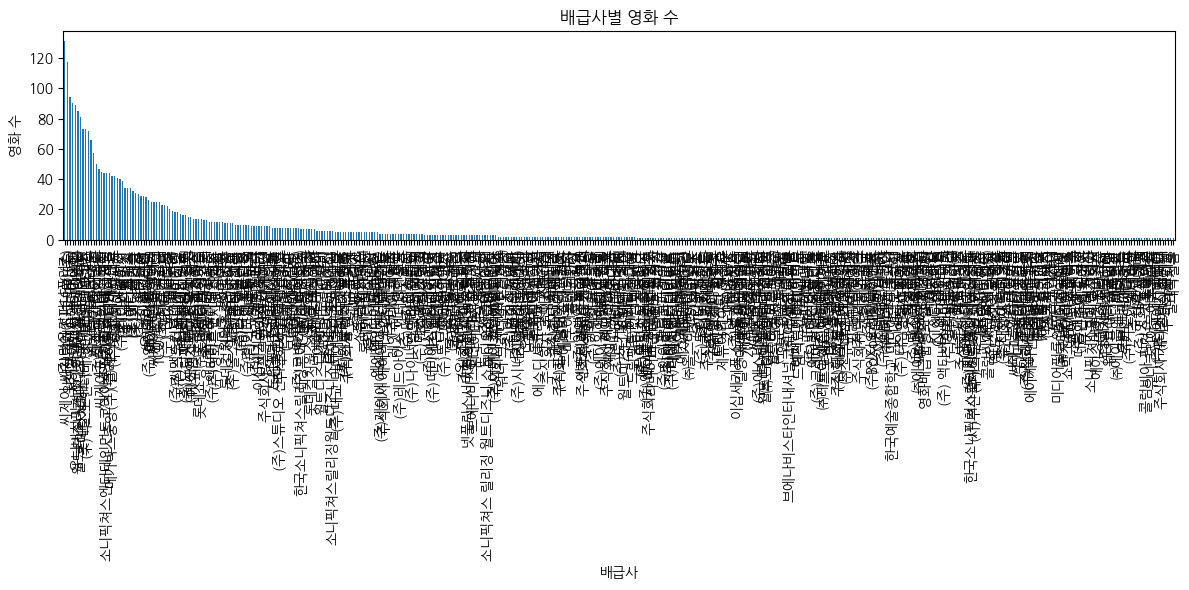

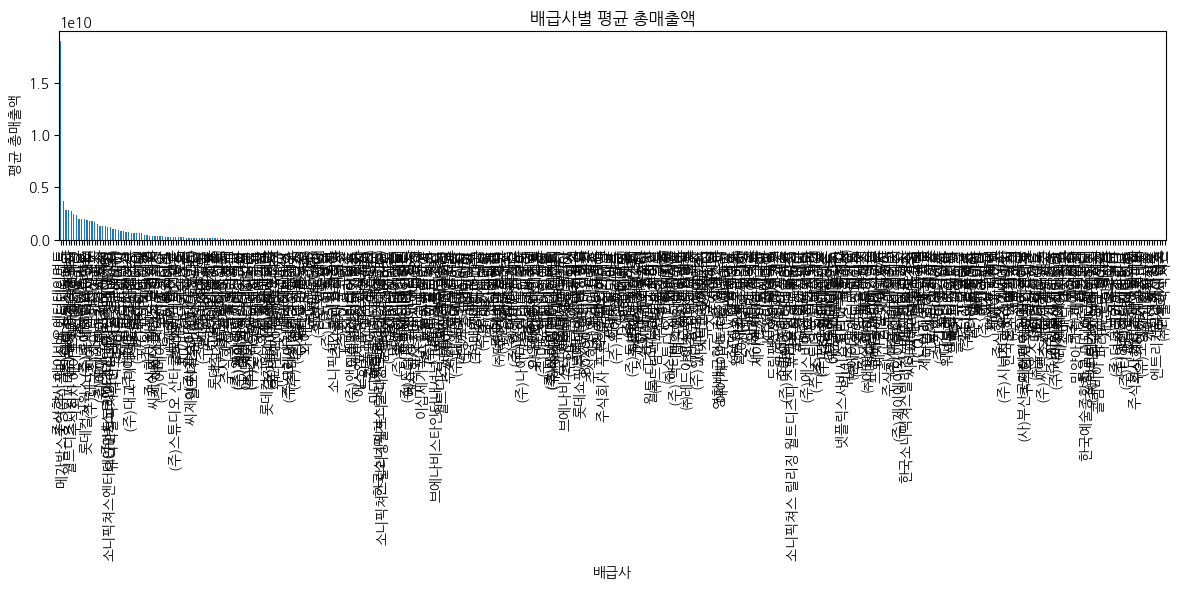

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 원본 df를 보존하기 위해 복사본 생성
df_copy = df.copy()

# 1) '배급사' 컬럼을 NaN → '' 처리한 뒤, 쉼표(,) 기준으로 리스트로 변환
df_copy['배급사_list'] = df_copy['배급사'].fillna('').str.split(',')

# 2) explode를 이용해 배급사별로 한 행씩 분리
df_exploded = df_copy.explode('배급사_list')

# 3) 빈 문자열(결측) 제거
df_exploded = df_exploded[df_exploded['배급사_list'] != '']

# 4-1) 배급사별 평균 상영일수 계산 및 시각화
distributor_mean_days = (
    df_exploded
    .groupby('배급사_list')['상영일수']
    .mean()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 6))
distributor_mean_days.plot(kind='bar')
plt.xlabel('배급사')
plt.ylabel('평균 상영일수')
plt.title('배급사별 평균 상영일수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4-2) 배급사별 영화 수 계산 및 시각화
distributor_counts = df_exploded['배급사_list'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
distributor_counts.plot(kind='bar')
plt.xlabel('배급사')
plt.ylabel('영화 수')
plt.title('배급사별 영화 수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4-3) 배급사별 평균 총매출액 계산 및 시각화
distributor_mean_revenue = (
    df_exploded
    .groupby('배급사_list')['총매출액']
    .mean()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 6))
distributor_mean_revenue.plot(kind='bar')
plt.xlabel('배급사')
plt.ylabel('평균 총매출액')
plt.title('배급사별 평균 총매출액')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 배급사 oof 점수

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# 1) 결과를 저장할 DataFrame 복사본 생성
df_result = df.copy()
df_result['distributor_oof_score'] = np.nan  # 여기에 영화별 배급사 OOF 점수를 채울 예정

# 2) KFold 설정 (예: 5-폴드, shuffle=True, random_state 고정)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3) 각 fold마다 “훈련(fold_train) → 배급사 점수 계산 → 검증(fold_val)에 영화별 배급사 최고 점수 할당” 수행
for train_idx, val_idx in kf.split(df_result):
    # 3-1) 훈련용 subset
    df_train = df_result.iloc[train_idx]

    # 3-2) 훈련 subset에서 배급사별 영화 수와 평균 총매출액 계산을 위해 explode 준비
    df_train_dist = df_train.copy()
    df_train_dist['배급사_list'] = df_train_dist['배급사'].fillna('').str.split(',')
    df_train_dist = df_train_dist.explode('배급사_list')
    df_train_dist = df_train_dist[df_train_dist['배급사_list'] != '']  # 빈 문자열 제거

    # 3-3) 배급사별 “영화 수” 집계
    distributor_movie_count = df_train_dist['배급사_list'].value_counts()

    # 3-4) 배급사별 “평균 총매출액” 집계
    distributor_mean_revenue = df_train_dist.groupby('배급사_list')['총매출액'].mean()

    # 3-5) 로그 변환
    dist_count_log = np.log1p(distributor_movie_count)       # log(1 + 영화 수)
    dist_rev_log = np.log1p(distributor_mean_revenue)        # log(1 + 평균매출)

    # 3-6) Min–Max 스케일링
    dc_min, dc_max = dist_count_log.min(), dist_count_log.max()
    dr_min, dr_max = dist_rev_log.min(), dist_rev_log.max()

    distributor_count_scaled = (dist_count_log - dc_min) / (dc_max - dc_min)
    distributor_rev_scaled = (dist_rev_log - dr_min) / (dr_max - dr_min)

    # 3-7) 최종 배급사 점수 계산 (영화 수 vs 평균매출 평균)
    distributor_score = (distributor_count_scaled + distributor_rev_scaled) / 2
    default_distributor_score = distributor_score.mean()  # 훈련 내 전체 배급사 평균

    # 3-8) 검증용 subset(fold_val)에 영화별 배급사 최고 점수 할당
    for idx in val_idx:
        movie_idx = df_result.index[idx]
        distributor_str = df_result.at[movie_idx, '배급사']

        # 배급사 데이터가 없으면 해당 fold의 전체 배급사 평균 점수로 채운다
        if pd.isna(distributor_str) or distributor_str.strip() == "":
            df_result.at[movie_idx, 'distributor_oof_score'] = default_distributor_score
            continue

        dist_list = [d.strip() for d in distributor_str.split(',') if d.strip() != ""]
        d_scores = distributor_score.reindex(dist_list).fillna(default_distributor_score)

        # 영화별 “배급사 최고 점수” = 출연 배급사 점수들의 최대값
        df_result.at[movie_idx, 'distributor_oof_score'] = d_scores.max()

# 4) 결과: df_result['distributor_oof_score'] 열에 영화별 배급사 OOF 점수가 저장됨
print(df_result[['배급사', 'distributor_oof_score']].head())


                                        배급사  distributor_oof_score
0                     메가박스중앙(주) 플러스엠 엔터테인먼트               0.839670
1  메가박스중앙(주) 플러스엠 엔터테인먼트,(주)미디어캐슬,워터홀컴퍼니(주)               0.806941
2                       (주)넥스트엔터테인먼트월드(NEW)               0.857507
3                                   판씨네마(주)               0.574967
4              (주)바이포엠스튜디오,(주)대교 미디어콘텐츠사업본부               0.614493


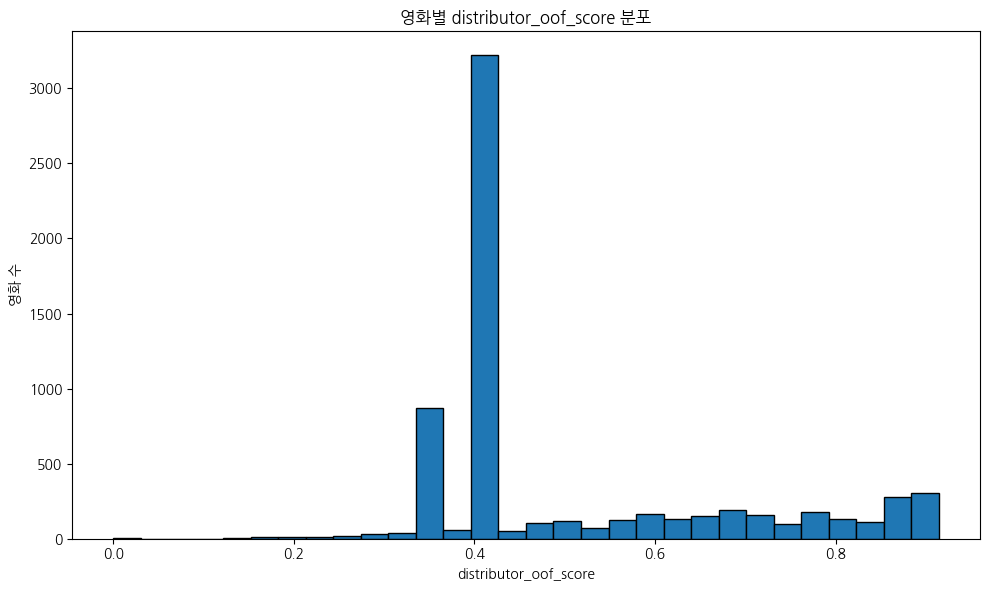

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_result['distributor_oof_score'].dropna(), bins=30, edgecolor='black')
plt.xlabel('distributor_oof_score')
plt.ylabel('영화 수')
plt.title('영화별 distributor_oof_score 분포')
plt.tight_layout()
plt.show()

In [61]:
# director_oof_score 기준으로 내림차순 정렬
df_result = df_result.sort_values(by='distributor_oof_score', ascending=False).reset_index(drop=True)
df_result[['영화명', '배급사', '상영일수', 'distributor_oof_score']]

,영화명,배급사,상영일수,distributor_oof_score
0,소울,월트디즈니컴퍼니코리아 유한책임회사,146,0.914146
1,앤트맨과 와스프,월트디즈니컴퍼니코리아 유한책임회사,7,0.914146
2,어벤져스: 인피니티 워,월트디즈니컴퍼니코리아 유한책임회사,7,0.914146
3,비틀즈 겟 백: 루프탑 콘서트,월트디즈니컴퍼니코리아 유한책임회사,3,0.914146
4,가디언즈 오브 갤럭시: Volume 3,월트디즈니컴퍼니코리아 유한책임회사,97,0.914146
...,...,...,...,...
6645,잔다르크,조이앤시네마,8,0.121114
6646,듄: 드리프터,㈜스토리제이,22,0.051434
6647,19금 비밀과외,영화사 산들바람,1,0.020665
6648,이웃집 BJ,케이제이픽처스,1,0.000000


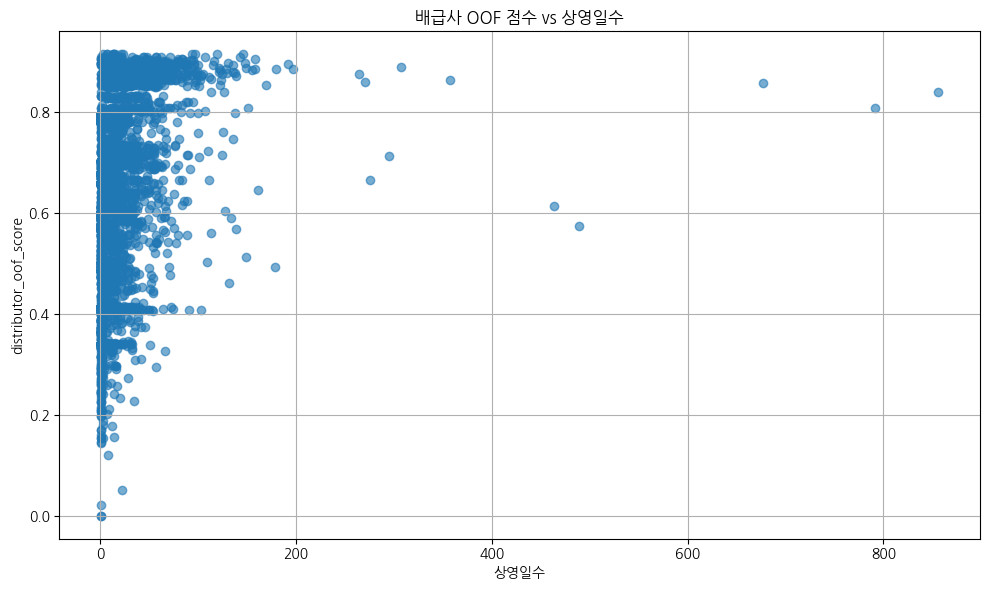

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_result['상영일수'], df_result['distributor_oof_score'], alpha=0.6)
plt.xlabel('상영일수')
plt.ylabel('distributor_oof_score')
plt.title('배급사 OOF 점수 vs 상영일수')
plt.grid(True)
plt.tight_layout()
plt.show()
